# Classifying Fake News with Machine Learning

**DATA URL:**
https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

**Problem:** Fake news is an obstacle to the effective functionining of our most important institutions. Fake news undermines legitimate and established systems processes, and encourages the dissemination of false information. Fake news can often be hard to indentify, but with advances in Natural Language Processing, it is now possible to extract meaning and signficance from large amounts of text data. Implementing an effective tool than can classify false news accuratley could be a signficant step towards restoring trust in our media and institutions. 

**Data Driven Solution:** Can we build a machine-learning model that can succesfully classify news articles as fake or real?

**Modelling Strategy:** The problem stated above is a classical classification problem, and there are a number of models that could be deployed. We chose to deploy several classification models, which included Naive Bayes, Support Vector Machine and Logistic Regression, and all of which performed well. Ultimatley, after processing the text with a tfidf vectorizer, fitting a ML pipeline, and subsequently tuning the optimum model parameters through a Grid Search, the SVM model performed best with a **test accuracy of 0.98%.** 

In [15]:
#Load necessary packages:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

import json
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB        
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

import nltk
import nltk as nlp
from nltk.stem.snowball import SnowballStemmer
# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from textblob import TextBlob, Word
from collections import Counter
from wordcloud import WordCloud,STOPWORDS

/Users/joseph_arber/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Let's load in the data and take a quick look:

In [16]:
true = pd.read_csv("data/fake-news/True.csv")
fake = pd.read_csv("data/fake-news/Fake.csv")

In [18]:
true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [19]:
fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

### Dataset Details

**The data frames contain:**

  1. 'title' - name of article
  2. 'text' - subject text 
  3. 'subject' - category of the article
  4. 'date' - when was article published

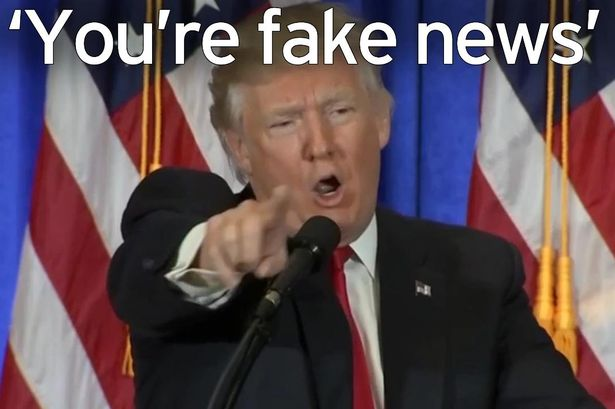

Let's directly concatenate the fake and true news stories into a df named 'news':

In [20]:
fake['target'] = 'fake'
true['target'] = 'true'
news = pd.concat([fake, true]).reset_index(drop = True)
news.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date target  
0  December 31, 2017   fake  
1  December 31, 2017   fake  
2  December 30, 2017   fake  
3  December 29, 2017   fake  
4  December 25, 2017   fake

In [21]:
news.tail()

title  \
44893  'Fully committed' NATO backs new U.S. approach...   
44894  LexisNexis withdrew two products from Chinese ...   
44895  Minsk cultural hub becomes haven from authorities   
44896  Vatican upbeat on possibility of Pope Francis ...   
44897  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
44893  BRUSSELS (Reuters) - NATO allies on Tuesday we...  worldnews   
44894  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
44895  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
44896  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
44897  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

                   date target  
44893  August 22, 2017    true  
44894  August 22, 2017    true  
44895  August 22, 2017    true  
44896  August 22, 2017    true  
44897  August 22, 2017    true

In [22]:
news.describe()

title   text  \
count                                               44898  44898   
unique                                              38729  38646   
top     Factbox: Trump fills top jobs for his administ...          
freq                                                   14    627   

             subject                date target  
count          44898               44898  44898  
unique             8                2397      2  
top     politicsNews  December 20, 2017    fake  
freq           11272                 182  23481

In [23]:
news.dtypes

title      object
text       object
subject    object
date       object
target     object
dtype: object

There are around 50,000 observations in the data frame.

In [9]:
len(news)

44898

We can use pandas profiling to quickly gain useful information and meaning from the dataset.

In [85]:
#Pandas profiling tool:
from pandas_profiling import ProfileReport 
report = ProfileReport(news)
report

# Exploratory Analysis

#### EDA Expecations

It is assumed that fake news articles will have one of the following characteristics:

1. Article title will adress the reader directly 
1. Sources will use very specific figures and numbers in the text body as well as the title
1. Fake news will make alarmist claims using strong adjectives 
   
Conducting an EDA will allow us to check whether these assumptions are met.



##### News Story Titles

In [58]:
news['title'].is_unique

False

The new stories are not unique. Let's take a look at the most popular news titles. We can also examine the most popular fake news titles.

/Users/joseph_arber/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


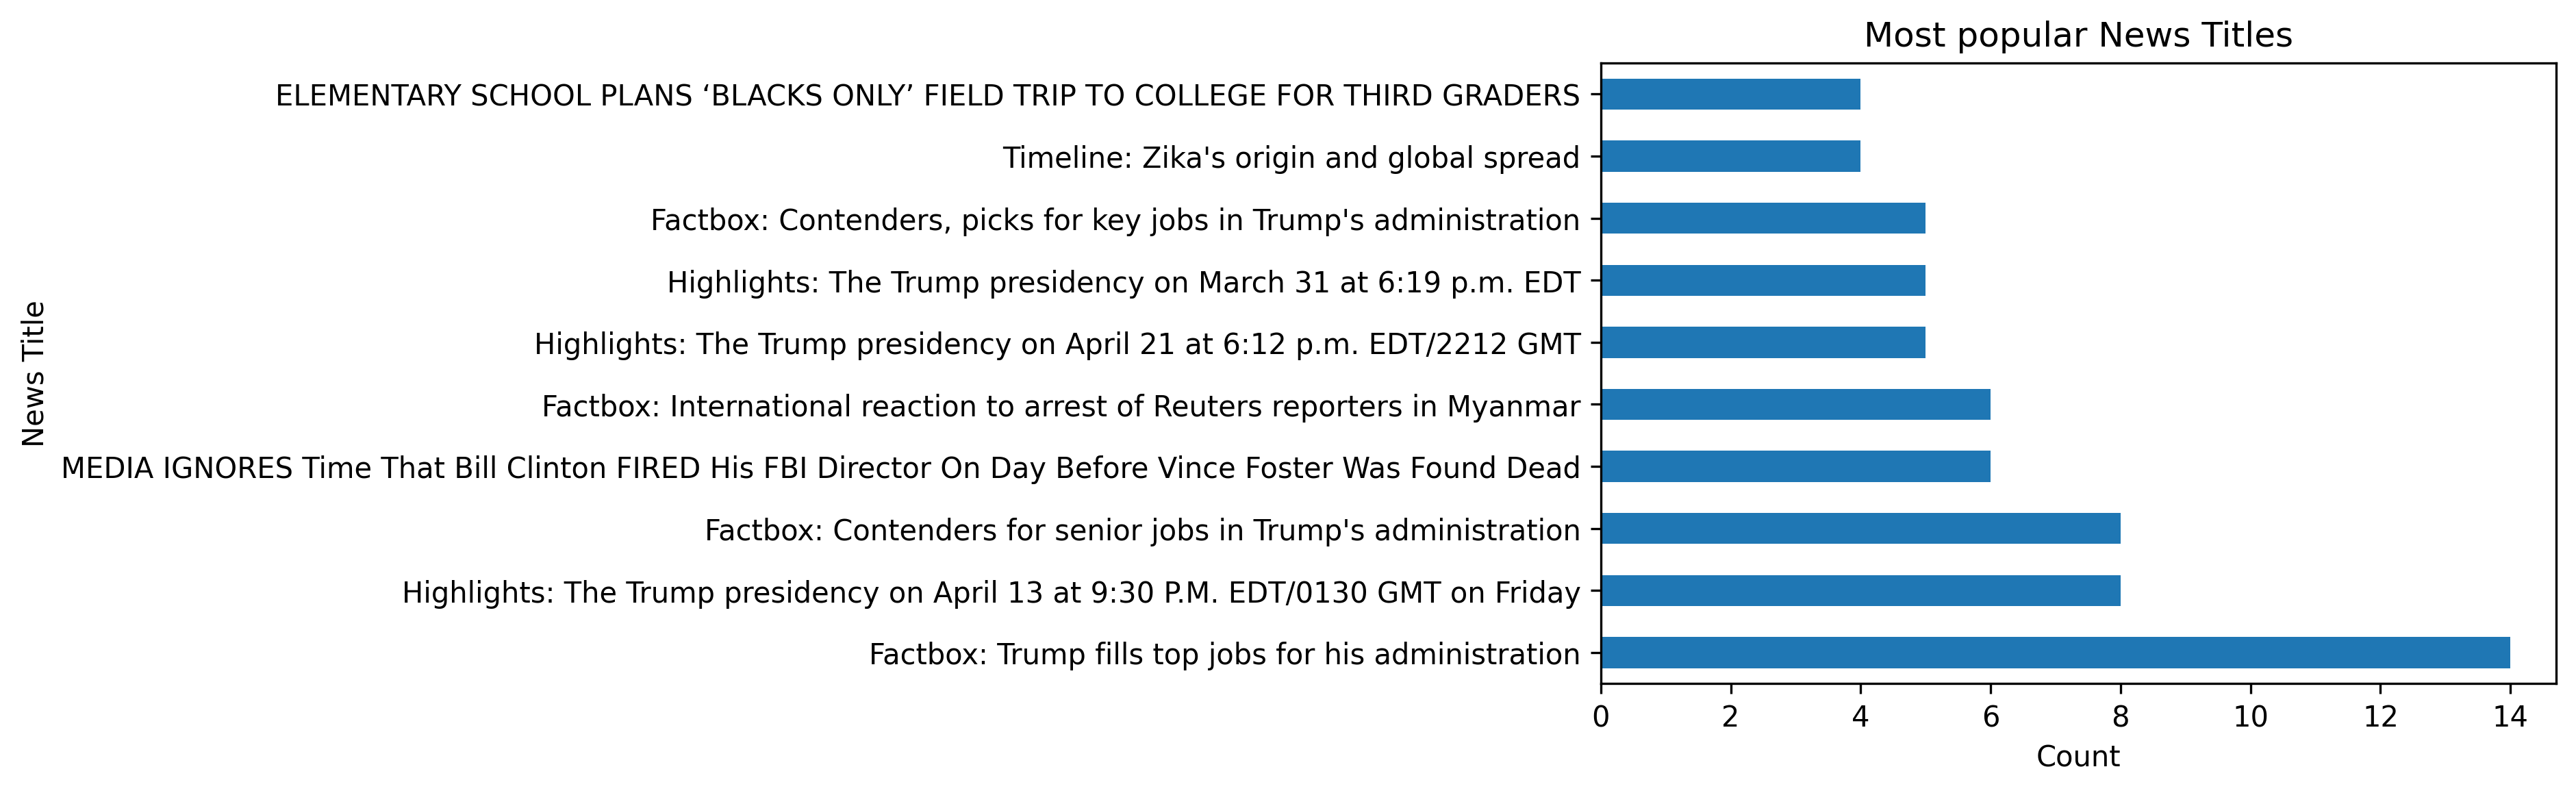

In [84]:
fg, ax = plt.subplots(dpi=300)
news['title'].value_counts().head(10).plot(kind='barh', ax=ax)
ax.set_title('Most popular News Titles')
ax.set_xlabel('Count')
ax.set_ylabel('News Title')
fg.tight_layout()

It seems that the most popular news titles are politics focussed. A number of the titles mention **Trump** indicating the influence the US President has on the news agenda.

/Users/joseph_arber/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


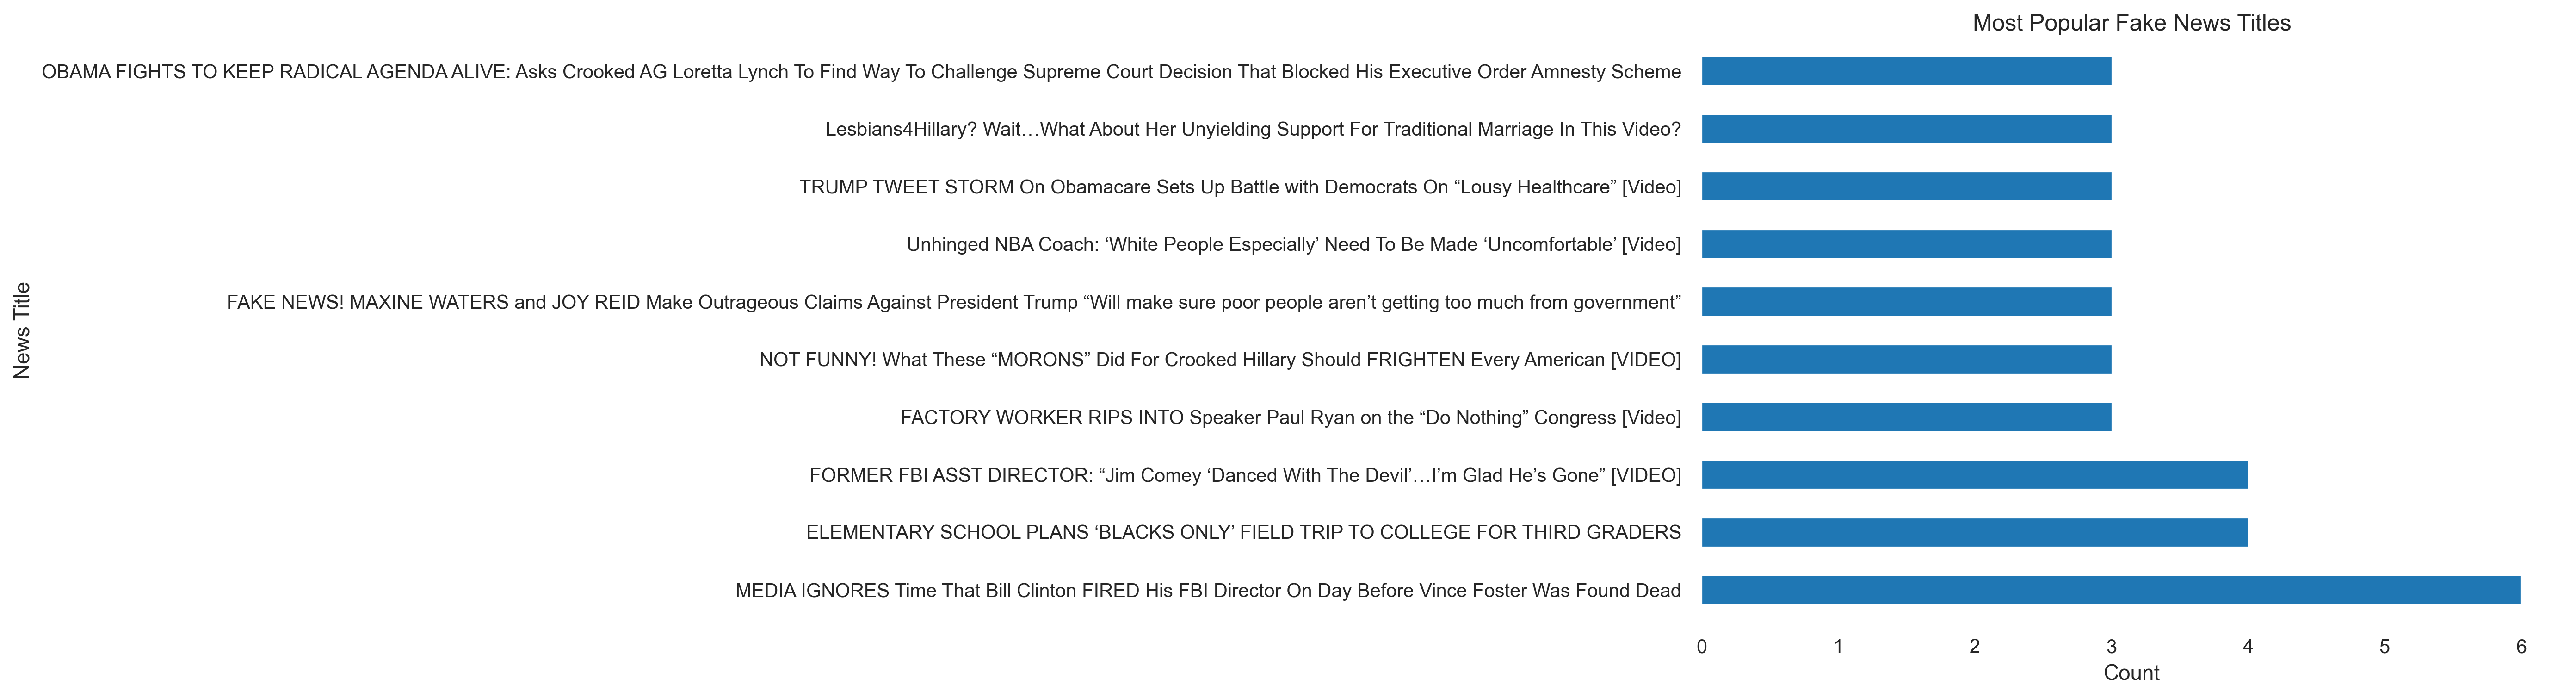

In [13]:
fg, ax = plt.subplots(dpi=300)
fake['title'].value_counts().head(10).plot(kind='barh', ax=ax)
ax.set_title('Most Popular Fake News Titles')
ax.set_xlabel('Count')
ax.set_ylabel('News Title')
fg.tight_layout()

The fake news titles tend to be longer, containing more random words, symbols and figures.

In [14]:
#Counting by Subjects 
for key,count in news.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#Getting Total Rows
print(f"Total Records:\t{news.shape[0]}")

politicsNews:	11272
worldnews:	10145
News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	44898


In [15]:
news.tail()

title  \
44893  'Fully committed' NATO backs new U.S. approach...   
44894  LexisNexis withdrew two products from Chinese ...   
44895  Minsk cultural hub becomes haven from authorities   
44896  Vatican upbeat on possibility of Pope Francis ...   
44897  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
44893  BRUSSELS (Reuters) - NATO allies on Tuesday we...  worldnews   
44894  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
44895  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
44896  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
44897  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

                   date target  
44893  August 22, 2017    true  
44894  August 22, 2017    true  
44895  August 22, 2017    true  
44896  August 22, 2017    true  
44897  August 22, 2017    true

In [16]:
#We need to clean this data, as there are some descriptions that do not help us. Let's merge the relevant values:

news1 = news.replace({"politicsNews":"politics"})

###### Popular News Subjects

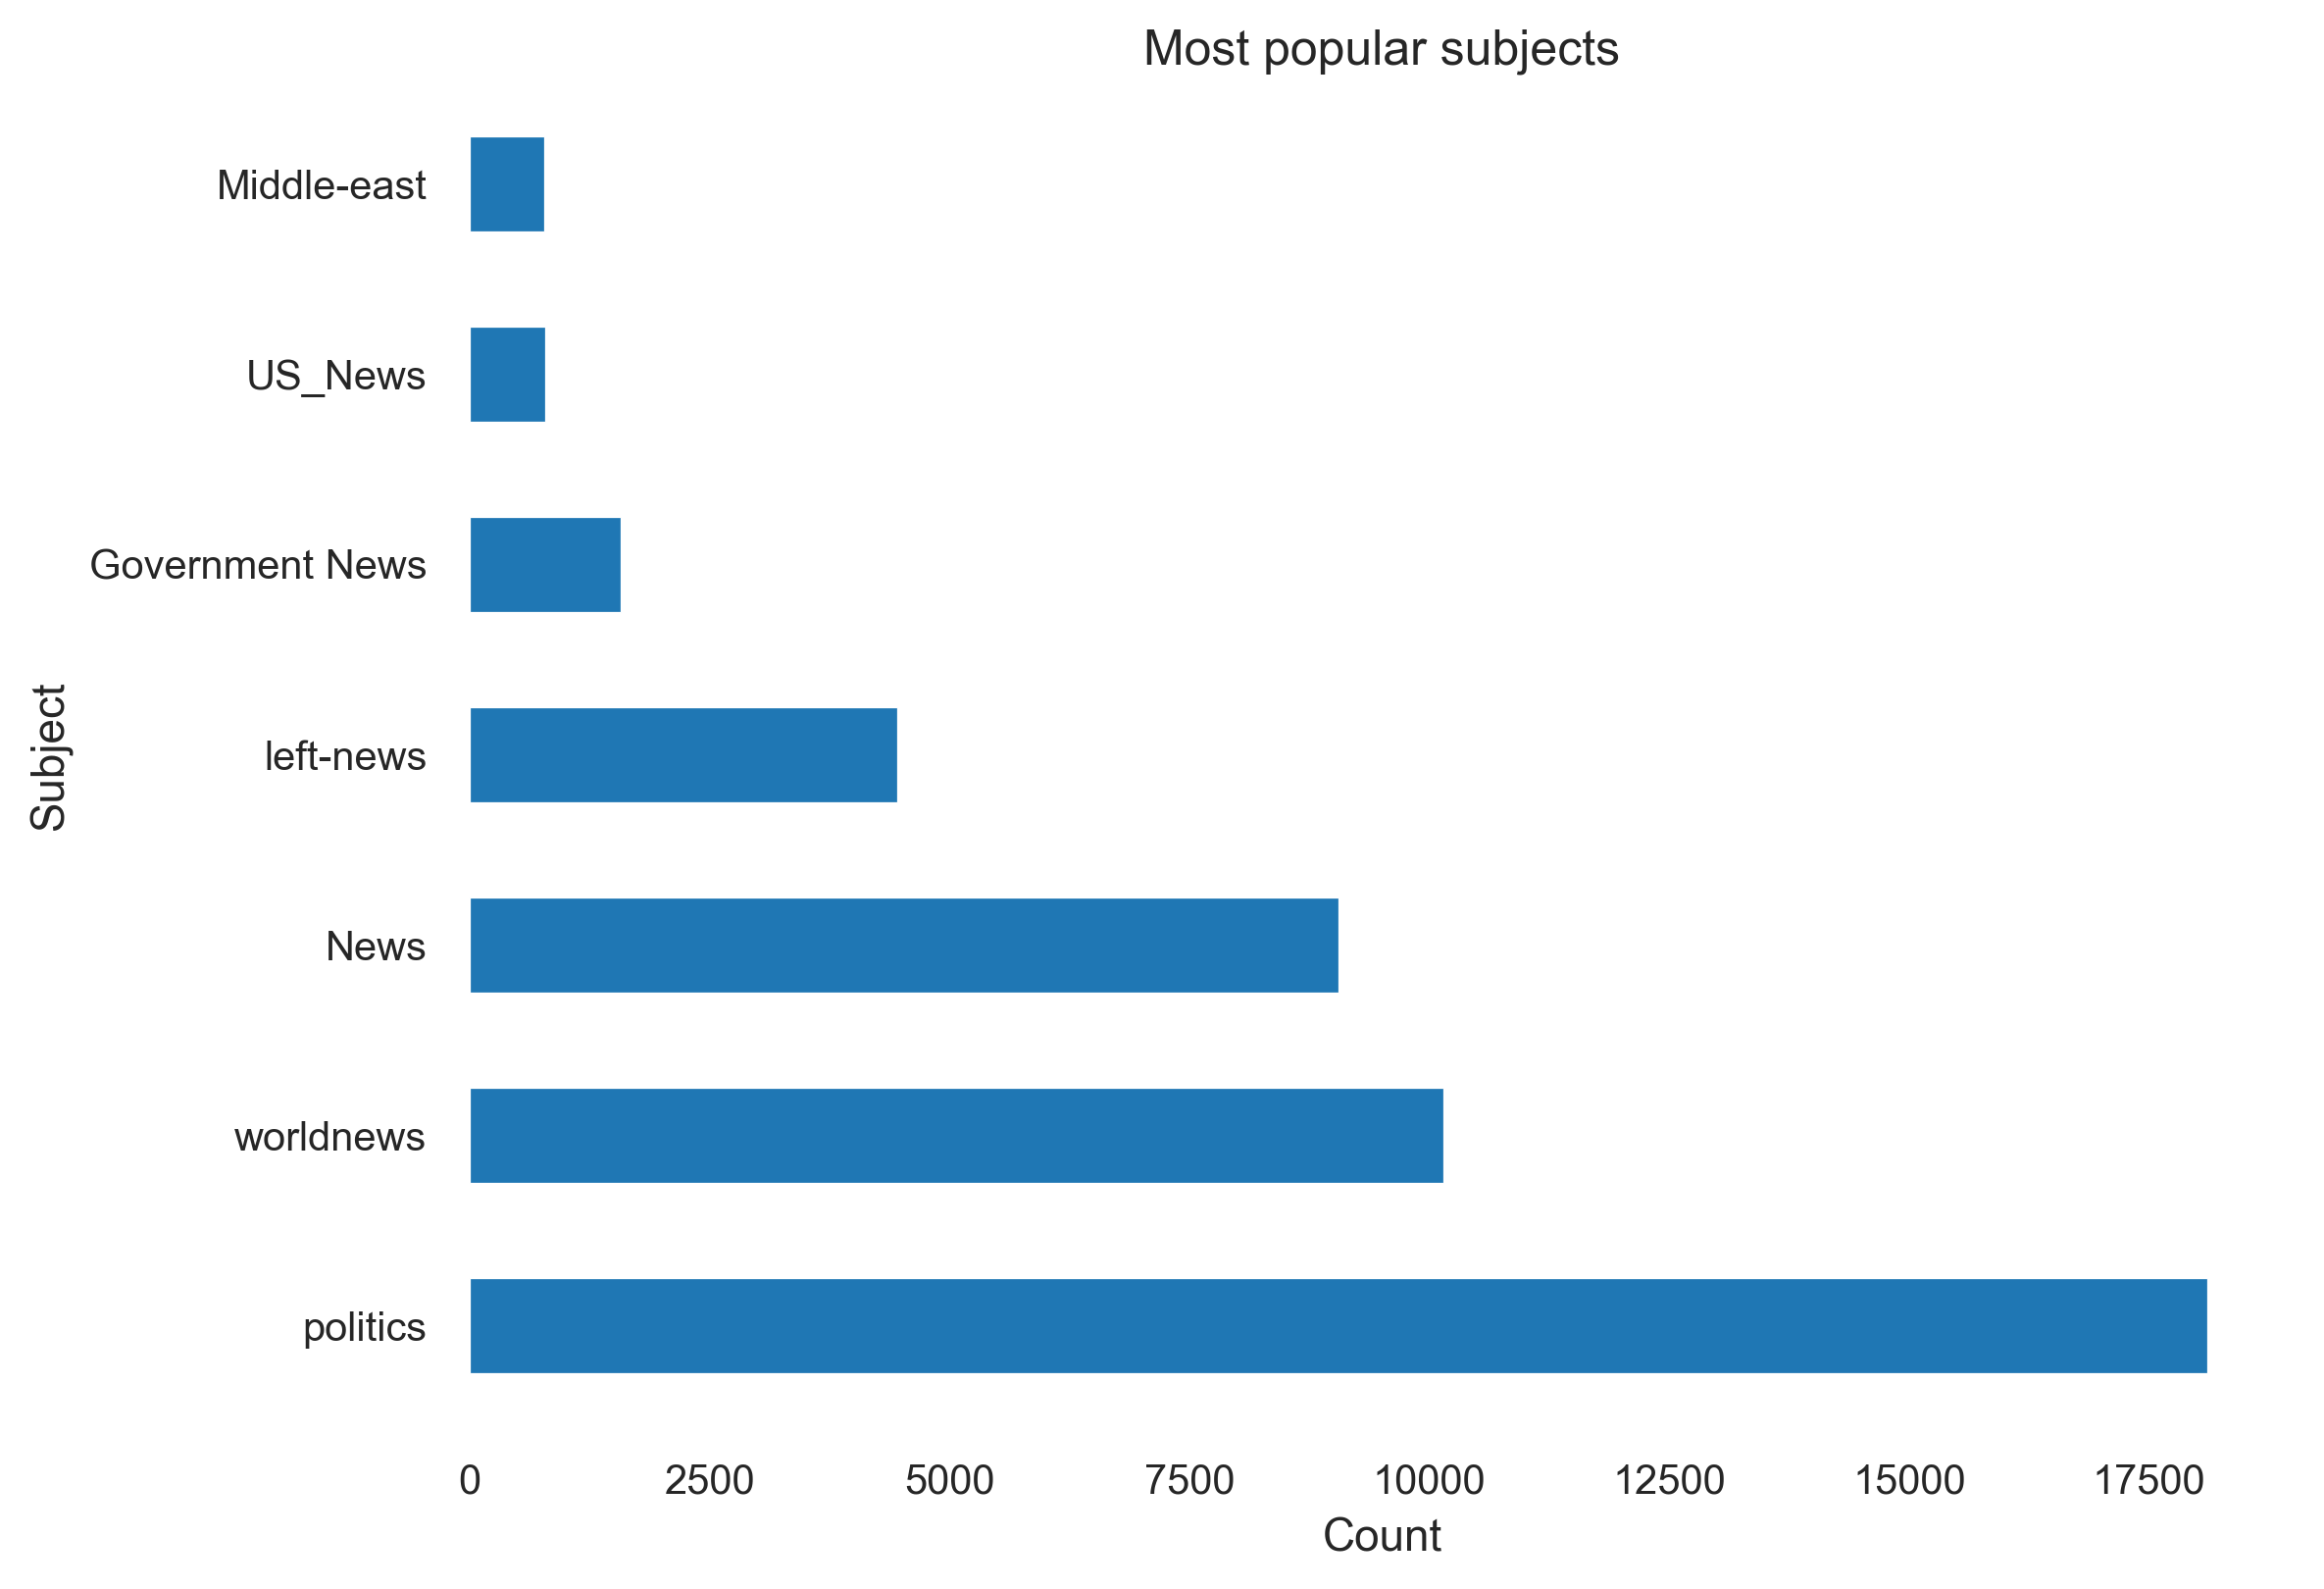

In [17]:
# Plot most popular subject categories using a bar plot 

fg, ax = plt.subplots(dpi=300)
news1['subject'].value_counts().head(15).plot(kind='barh', ax=ax)
ax.set_title('Most popular subjects')
ax.set_xlabel('Count')
ax.set_ylabel('Subject')
fg.tight_layout()

In [18]:
import plotly.graph_objects as go

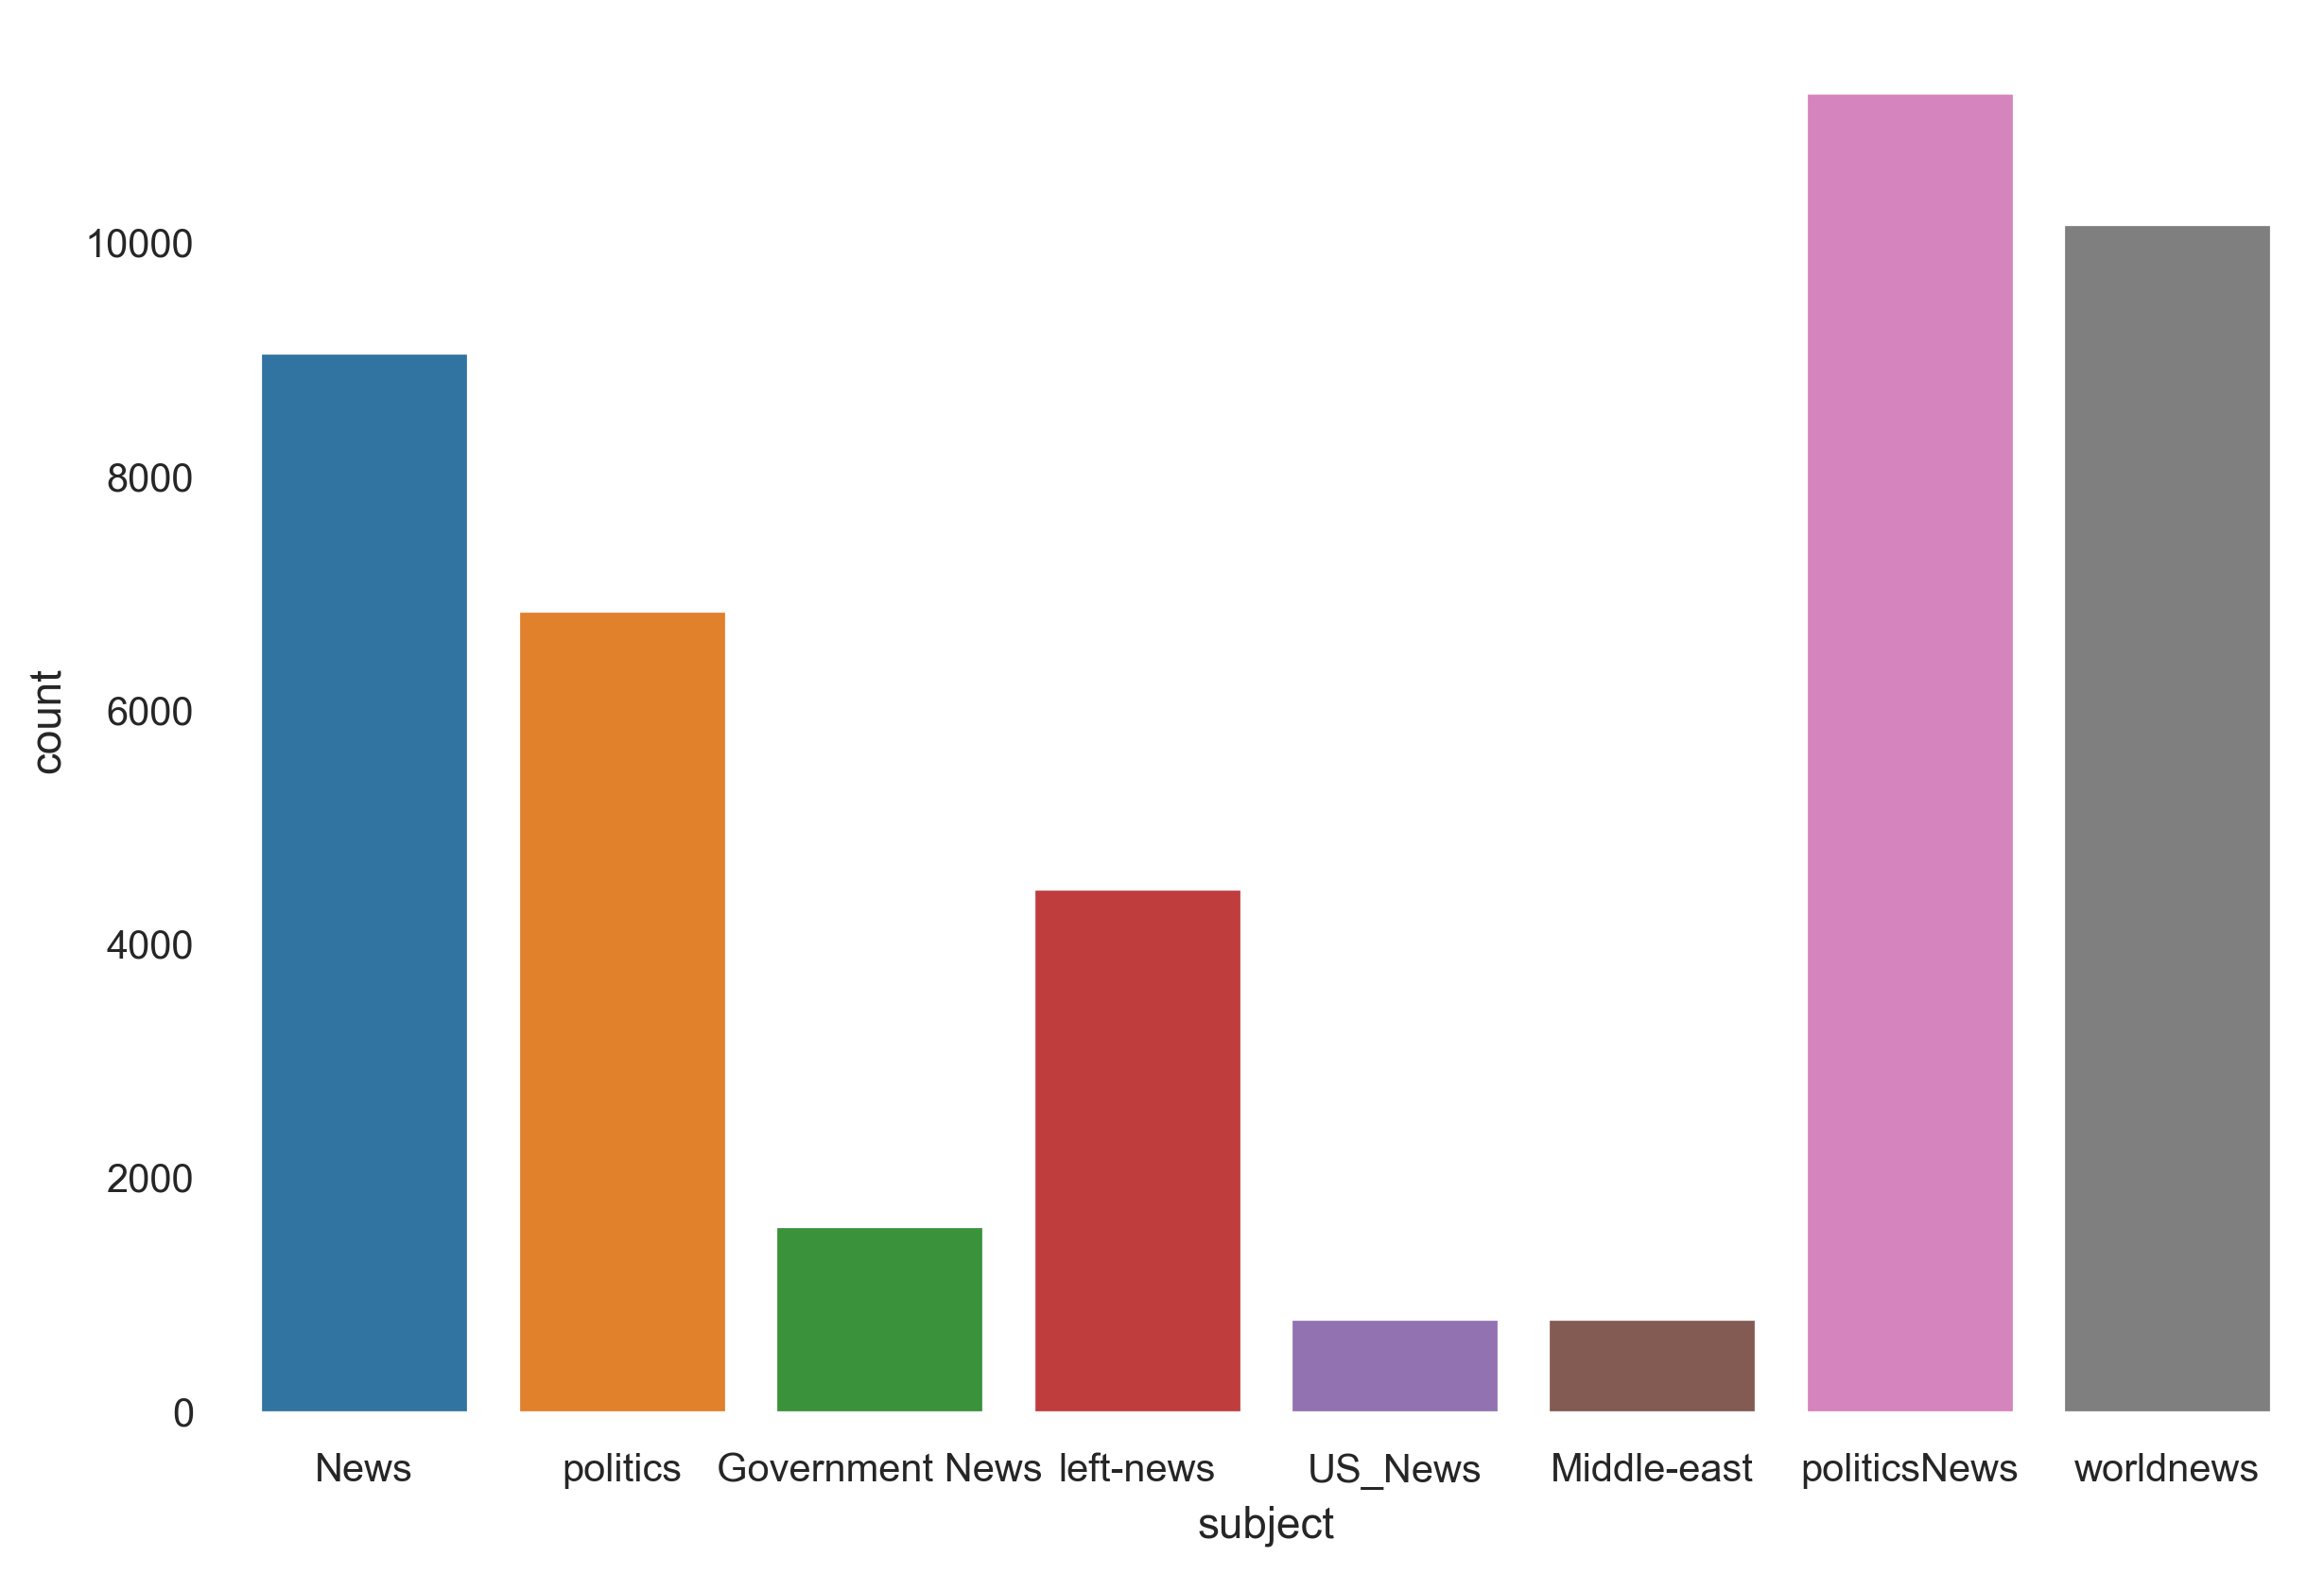

In [19]:
fg, ax = plt.subplots(dpi = 300)
fg.tight_layout()
sns.countplot("subject", data=news)
plt.show()

<Figure size 720x576 with 0 Axes>

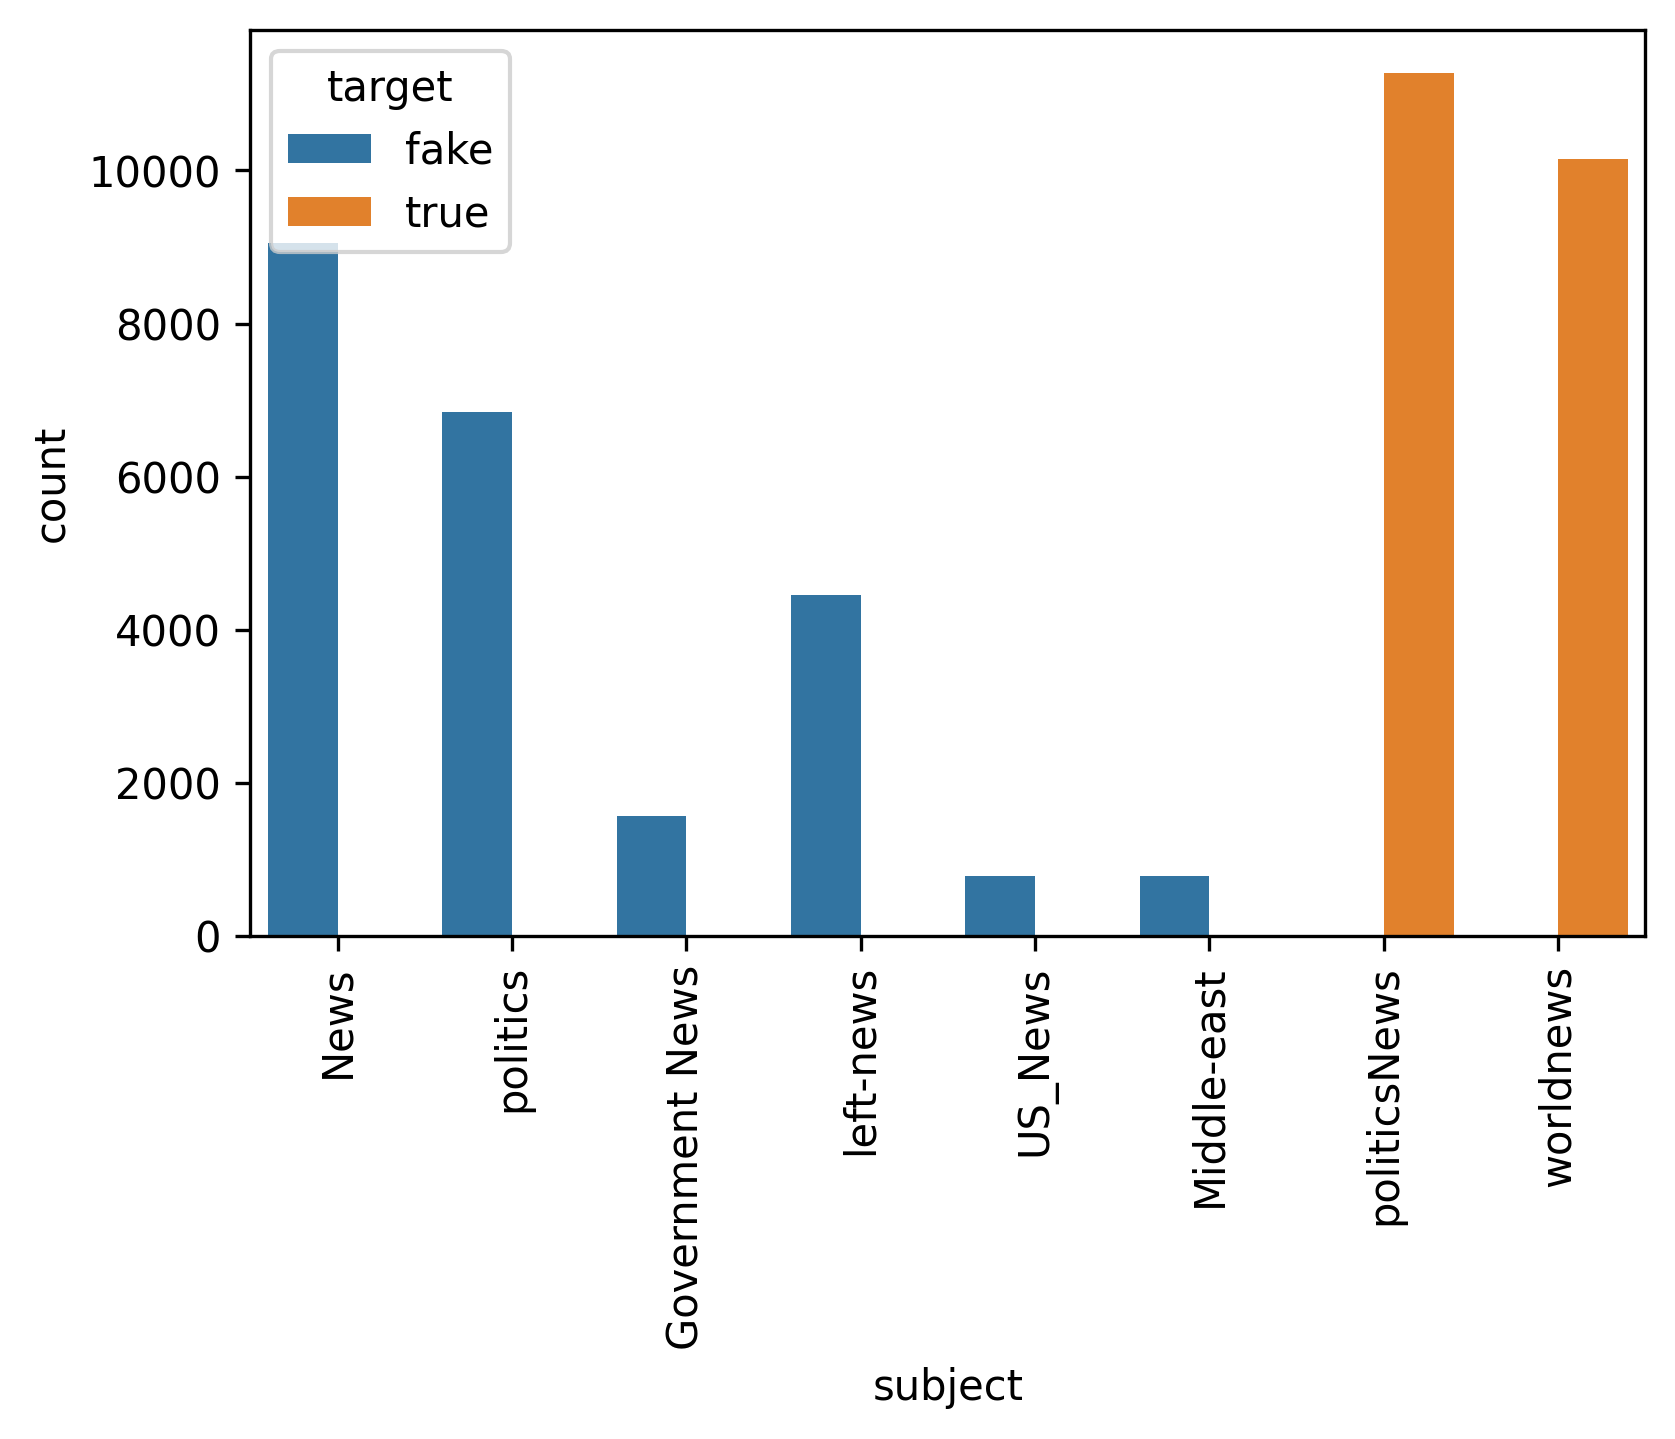

In [82]:
plt.figure(figsize=(10,8))

fg, ax = plt.subplots(dpi=300)

ax = sns.countplot(x="subject", hue="target", data=news)
plt.xticks(rotation=90)
plt.show()

In [35]:
news.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date target  title_length  text_length  fake  true  
0  December 31, 2017   fake            12          495     1     0  
1  December 31, 2017   fake             8          305     1     0  
2  December 30, 2017   fake            15          580     1     0  
3  December 29, 2017   fake            14          444     1     0  
4  December 25, 2017   fake            11          420     1     0

## Is there much differences between fake and real news stories?

Let's explore the length of fake news titles, do they use a lot of words in comparison to real news articles?

In [59]:
# Convert fake news value to a new binary/dummy variable:

fake['fake'] = 1
true['fake'] = 0

We need to concatenate the fake and true news dataframes as we did so above. We place it into a new dataframe called; 'news_1' as to not adversly impact our working dataframe **'news'**.

In [60]:
news_1 = pd.concat([fake, true], ignore_index=True)
news_1

title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
44893  'Fully committed' NATO backs new U.S. approach...   
44894  LexisNexis withdrew two products from Chinese ...   
44895  Minsk cultural hub becomes haven from authorities   
44896  Vatican upbeat on possibility of Pope Francis ...   
44897  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
0      Donald Trump just couldn t wish all Americans ...       News   
1      House Intelligence Committee Chairman Devin Nu...       News   
2      On Friday, it was revealed that former Milwauk...       News   
3      On Christmas day, Donald Trump announced that ...       News   
4      Pope Francis used his annual Christmas Day mes...       News   
...                                                  ...        ...   
44893  BRUSSELS (Reuters) - NATO allies on Tuesday we...  worldnews   
44894  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
44895  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
44896  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
44897  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

                    date target  fake  
0      December 31, 2017   fake     1  
1      December 31, 2017   fake     1  
2      December 30, 2017   fake     1  
3      December 29, 2017   fake     1  
4      December 25, 2017   fake     1  
...                  ...    ...   ...  
44893   August 22, 2017    true     0  
44894   August 22, 2017    true     0  
44895   August 22, 2017    true     0  
44896   August 22, 2017    true     0  
44897   August 22, 2017    true     0  

[44898 rows x 6 columns]

In [61]:
# Let's use the apply function so that we can split the length of the text and title columns for each observation

news_1['title_length'] = news_1['title'].apply(lambda x : len(x.strip().split()))
news_1['text_length'] = news_1['text'].apply(lambda x : len(x.strip().split()))

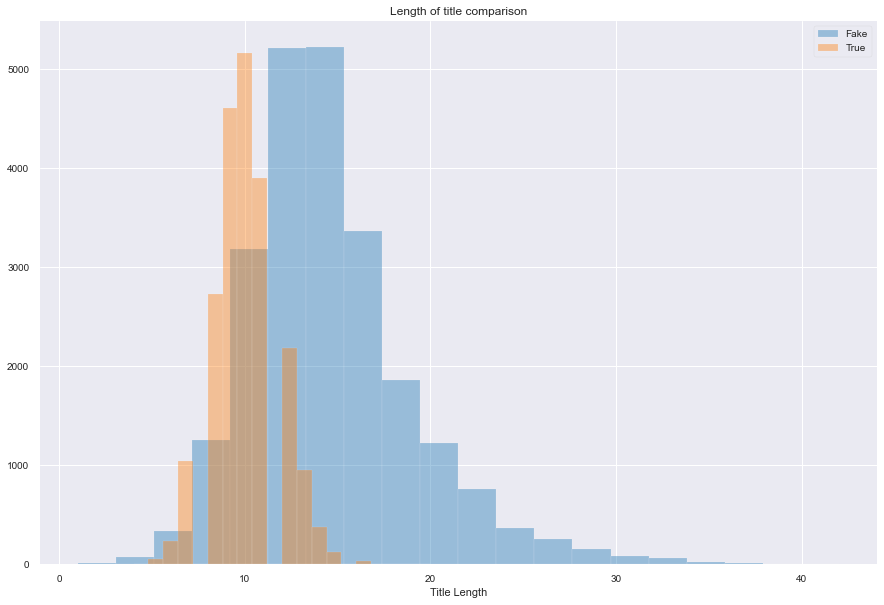

In [62]:
# Plot the length of true and fake news titles. Is there a difference?

sns.set_style('darkgrid')

plt.figure(figsize=(15,10))

sns.distplot(news_1[news_1['fake'] == 1]['title_length'], 
             kde=False, label='Fake', bins=20)
sns.distplot(news_1[news_1['fake'] == 0]['title_length'], 
             kde=False, label='True', bins=20)
plt.xlabel('Title Length')
plt.title('Length of title comparison')
plt.legend()

plt.show()

#### Findings:

Here we can see that **fake news** articles have far longer titles than **real news** articles. This finding confirms to the intial hypothesis that fake news often dramatizes topics, and uses more emotive or descriptive words.

This information will be useful in forming the rationale for our model selection criteria. 

No handles with labels found to put in legend.


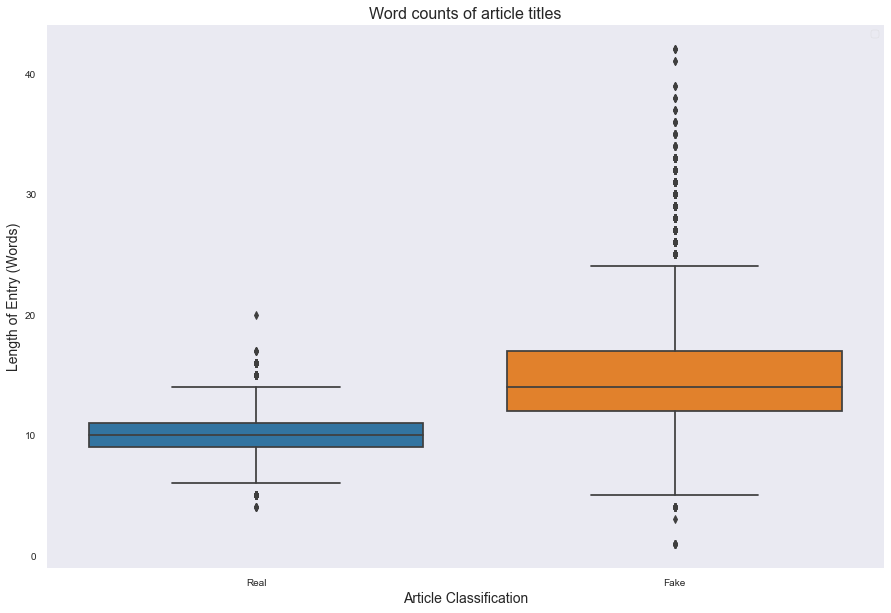

In [64]:
fig = plt.figure(figsize=(15, 10))

sns.set_style('dark')

plt.title("Word counts of article titles", fontsize=16)
ax = sns.boxplot(x="fake", y="title_length", data=news_1)
ax.set_xticklabels(['Real', 'Fake'])
ax.set_xlabel("Article Classification", fontsize=14) 
ax.set_ylabel("Length of Entry (Words)", fontsize=14)
plt.legend()

plt.show()

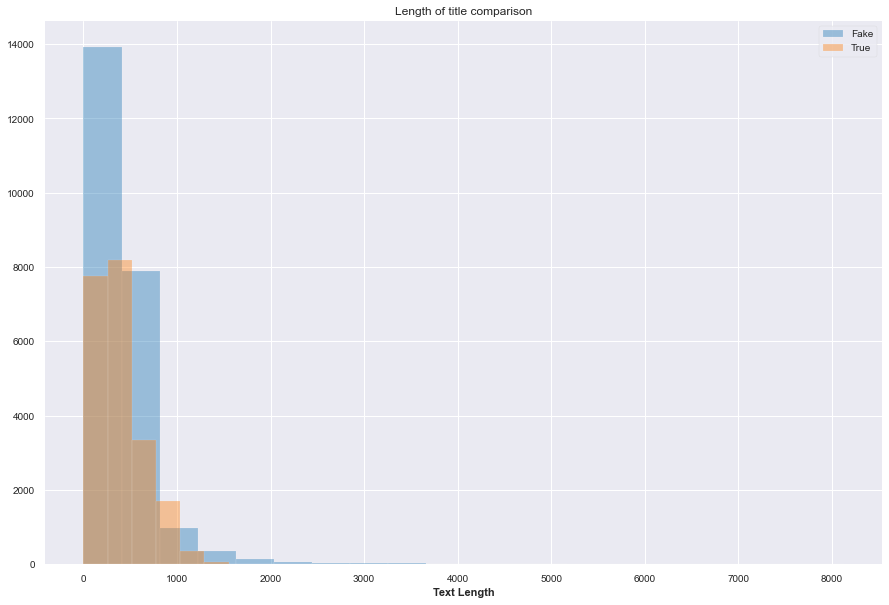

In [65]:
sns.set_style('darkgrid')


plt.figure(figsize=(15,10))
sns.distplot(news_1[news_1['fake'] == 1]['text_length'], 
             kde=False, label='Fake', bins=20)
sns.distplot(news_1[news_1['fake'] == 0]['text_length'], 
             kde=False, label='True', bins=20)
plt.xlabel('Text Length', weight='bold')
plt.title('Length of title comparison')

plt.legend()
plt.show()

In general, we can classify fake new articles as being; (1) longer in length, including title and text (2) using more words per title and text than real news articles. We could perhaps classify articles as fake or real using only the length.

### What topics do fake news stories focus on?

Let's plot in word cloud, the most common words used in **fake text** articles.

In [79]:
print((news.text[7]))

In the wake of yet another court decision that derailed Donald Trump s plan to bar Muslims from entering the United States, the New York Times published a report on Saturday morning detailing the president s frustration at not getting his way   and how far back that frustration goes.According to the article, back in June, Trump stomped into the Oval Office, furious about the state of the travel ban, which he thought would be implemented and fully in place by then. Instead, he fumed, visas had already been issued to immigrants at such a rate that his  friends were calling to say he looked like a fool  after making his broad pronouncements.It was then that Trump began reading from a document that a top advisor, noted white supremacist Stephen Miller, had handed him just before the meeting with his Cabinet. The page listed how many visas had been issued this year, and included 2,500 from Afghanistan (a country not on the travel ban), 15,000 from Haiti (also not included), and 40,000 from 

In [80]:
# Save it as a TextBlob object.
article = TextBlob(news.text[7])

In [81]:
# List the words.
article.words

WordList(['In', 'the', 'wake', 'of', 'yet', 'another', 'court', 'decision', 'that', 'derailed', 'Donald', 'Trump', 's', 'plan', 'to', 'bar', 'Muslims', 'from', 'entering', 'the', 'United', 'States', 'the', 'New', 'York', 'Times', 'published', 'a', 'report', 'on', 'Saturday', 'morning', 'detailing', 'the', 'president', 's', 'frustration', 'at', 'not', 'getting', 'his', 'way', 'and', 'how', 'far', 'back', 'that', 'frustration', 'goes.According', 'to', 'the', 'article', 'back', 'in', 'June', 'Trump', 'stomped', 'into', 'the', 'Oval', 'Office', 'furious', 'about', 'the', 'state', 'of', 'the', 'travel', 'ban', 'which', 'he', 'thought', 'would', 'be', 'implemented', 'and', 'fully', 'in', 'place', 'by', 'then', 'Instead', 'he', 'fumed', 'visas', 'had', 'already', 'been', 'issued', 'to', 'immigrants', 'at', 'such', 'a', 'rate', 'that', 'his', 'friends', 'were', 'calling', 'to', 'say', 'he', 'looked', 'like', 'a', 'fool', 'after', 'making', 'his', 'broad', 'pronouncements.It', 'was', 'then', 't

In [82]:
article.sentences

[Sentence("In the wake of yet another court decision that derailed Donald Trump s plan to bar Muslims from entering the United States, the New York Times published a report on Saturday morning detailing the president s frustration at not getting his way   and how far back that frustration goes.According to the article, back in June, Trump stomped into the Oval Office, furious about the state of the travel ban, which he thought would be implemented and fully in place by then."),
 Sentence("Instead, he fumed, visas had already been issued to immigrants at such a rate that his  friends were calling to say he looked like a fool  after making his broad pronouncements.It was then that Trump began reading from a document that a top advisor, noted white supremacist Stephen Miller, had handed him just before the meeting with his Cabinet."),
 Sentence("The page listed how many visas had been issued this year, and included 2,500 from Afghanistan (a country not on the travel ban), 15,000 from Hait

In [83]:
# Some string methods are available.
review.lower()

TextBlob("donald trump just couldn t wish all americans a happy new year and leave it at that. instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  the former reality show star had just one job to do and he couldn t do it. as our country rapidly grows stronger and smarter, i want to wish all of my friends, supporters, enemies, haters, and even the very dishonest fake news media, a happy and healthy new year,  president angry pants tweeted.  2018 will be a great year for america! as our country rapidly grows stronger and smarter, i want to wish all of my friends, supporters, enemies, haters, and even the very dishonest fake news media, a happy and healthy new year. 2018 will be a great year for america!  donald j. trump (@realdonaldtrump) december 31, 2017trump s tweet went down about as welll as you d expect.what kind of president sends a new year s greeting like this despicable, petty, infantile gibberish? only trump! his lack of decency

In [41]:
# Find the top 30 words used

top_dict = {}
for c in news.columns:
    top = news[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'title': [(21428,
   '“You’re Not Welcome!” Obama As Welcome At Roseberg Funerals As Westboro Baptist Church Members [Videos]'),
  (15113,
   '“You’re Not Welcome!” Obama As Welcome At Roseberg Funerals As Westboro Baptist Church Members [Videos]'),
  (11729,
   '“Your rights are NOT superior to mine!” JUDGE JEANINE PIRRO Lets The Berkeley Protesters Have It! [Video]'),
  (16696,
   '“YOU’RE HIRED!” Trump Pulls Unemployed Vet From Audience And Hires Her On The Spot'),
  (14235,
   '“YOU’RE HIRED!” Trump Pulls Unemployed Vet From Audience And Hires Her On The Spot'),
  (11943,
   '“YOU ARE FAKE NEWS!” TRUMP DESTROYS CNN Right In The Middle Of Press Conference [VIDEO]'),
  (19149,
   '“Would You Rather Do A Job You Hate And Not Pay Taxes?”…How These ILLEGALS Answer This Question Tells You Everything You Need To Know About How They “Help” Our Economy [VIDEO]'),
  (16247,
   '“Would You Rather Do A Job You Hate And Not Pay Taxes?”…How These ILLEGALS Answer This Question Tells You Everythi

Let's first generate a word cloud visualisation of the words used in the **fake news stories** to see what words appear the most. The word cloud should also highlight some words that we may want to remove.

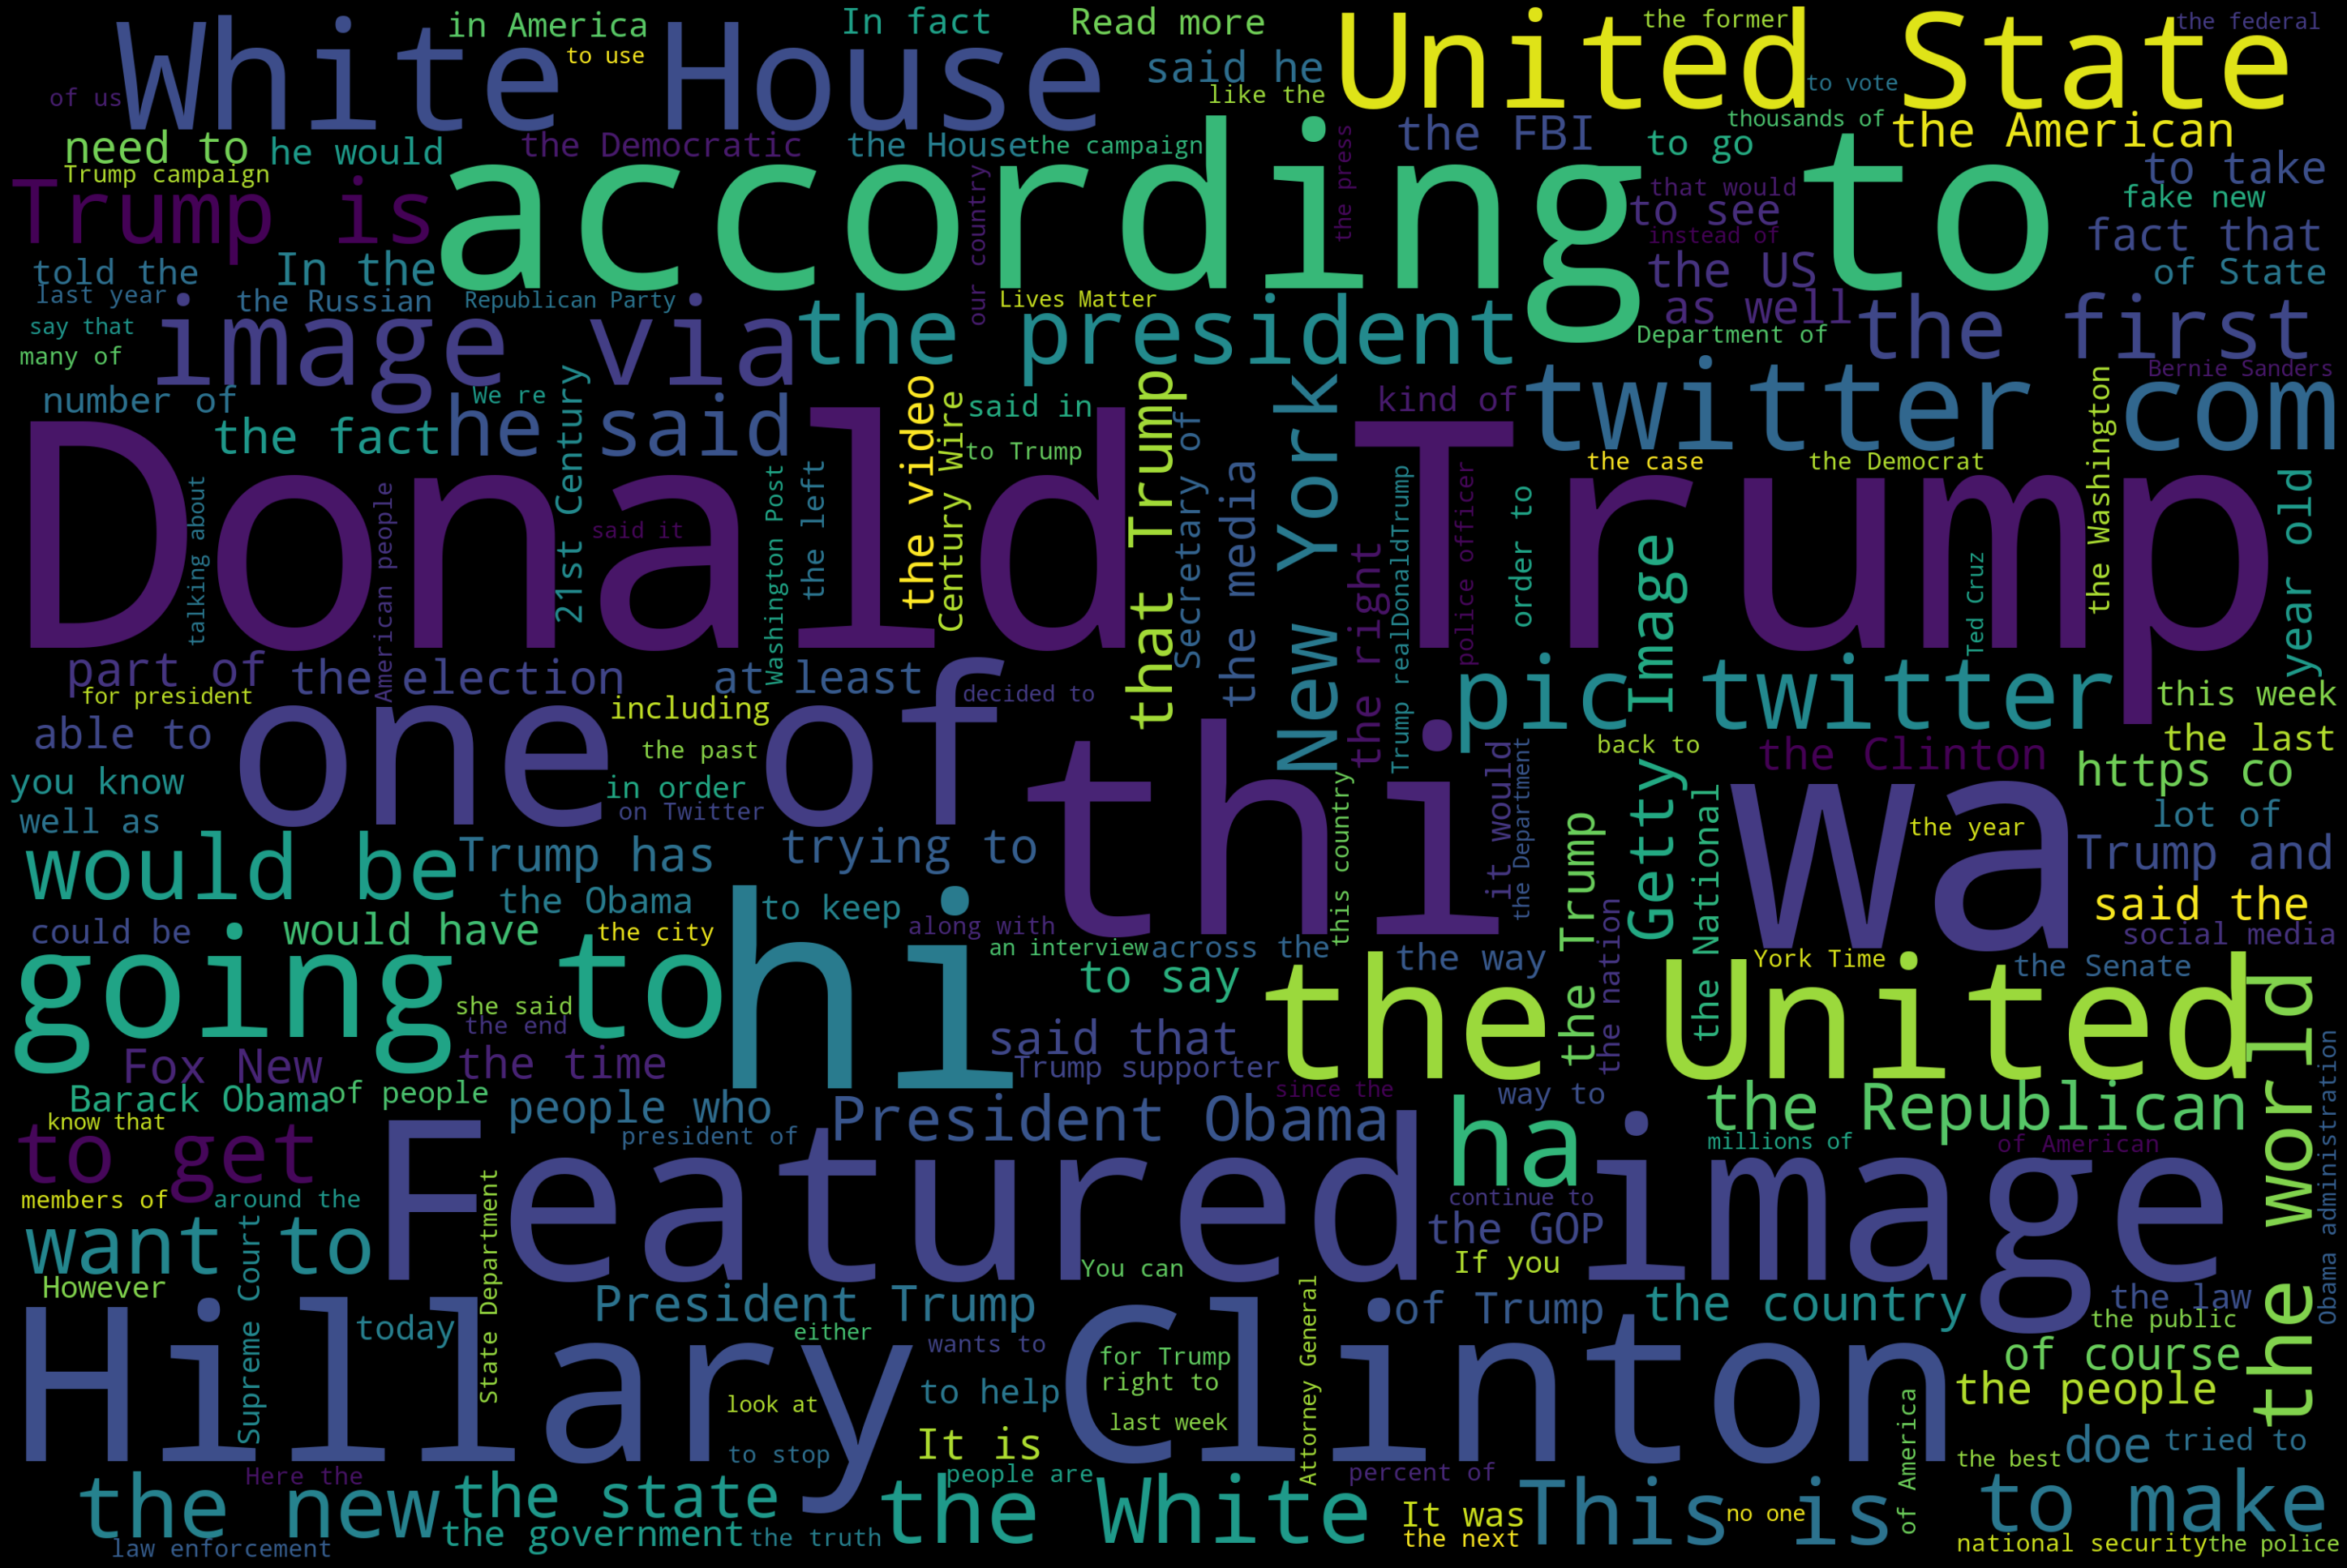

In [42]:
#Word Cloud

text = ''
for news in fake.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

Stop Words such as; 'to', 'in', 'on ', 'is' could potentially be removed later on!

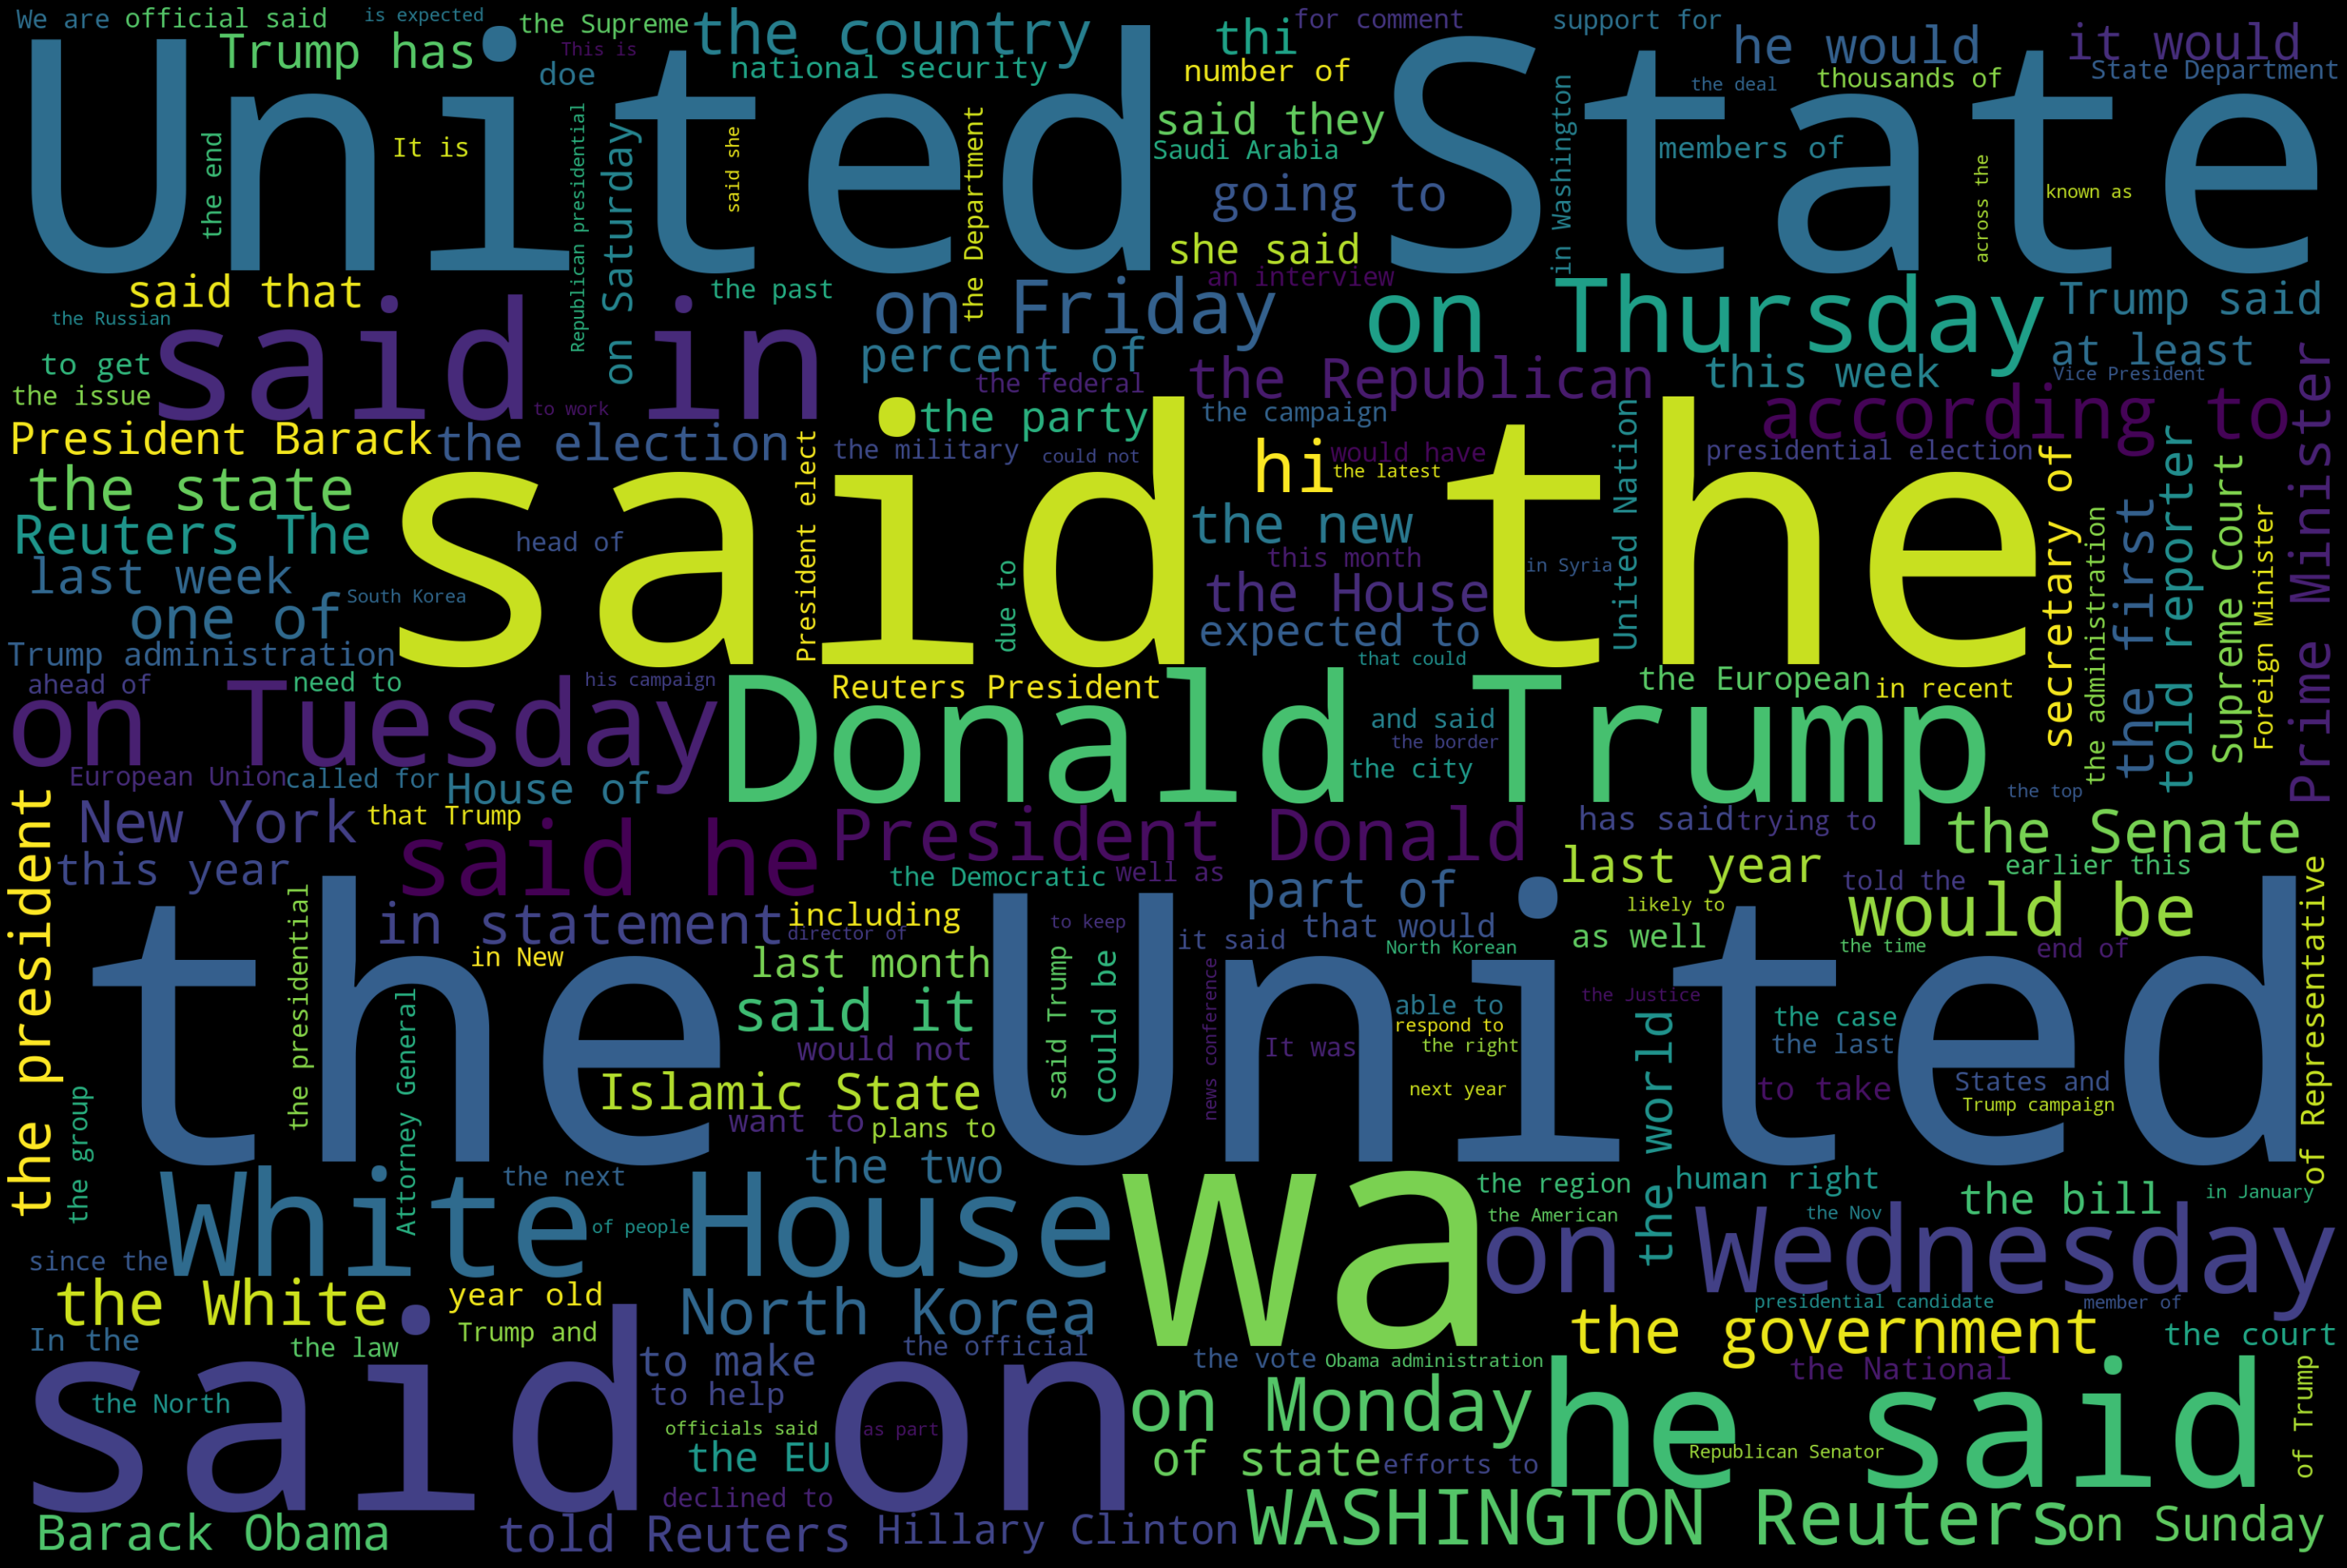

In [43]:
#WordCloud For Real News
text = ''
for news in true.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

In [ ]:
#from wordcloud import WordCloud, ImageColorGenerator

#text = " ".join(str(each) for each in news.text.unique())
#wordcloud = WordCloud(max_words=2000,stopwords = STOPWORDS, background_color="black",
                     #colormap="Dark2", max_font_size=150, random_state=42).generate(text)
#plt.figure(figsize=(40,30),
          #facecolor = 'k',
          #edgecolor = 'k')
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")
#plt.tight_layout(pad=0)
#plt.show()



# Data Cleaning & Pre-processing

#### Before proceeding with the analysis, we need to clean the textual data. This entails removing punctuation, stop words and other instances which could affect the performance of our classification algorithms.

**Removing Reuters or Twitter Tweet information from the text**

- Text can be splitted only once at " - " which is always present after mentioning source of publication, this gives us publication part and text part
- If we do not get text part, this means publication details was't given for that record
- The Twitter tweets always have same source, a long text of max 259 characters

In [21]:
news

title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
44893  'Fully committed' NATO backs new U.S. approach...   
44894  LexisNexis withdrew two products from Chinese ...   
44895  Minsk cultural hub becomes haven from authorities   
44896  Vatican upbeat on possibility of Pope Francis ...   
44897  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
0      Donald Trump just couldn t wish all Americans ...       News   
1      House Intelligence Committee Chairman Devin Nu...       News   
2      On Friday, it was revealed that former Milwauk...       News   
3      On Christmas day, Donald Trump announced that ...       News   
4      Pope Francis used his annual Christmas Day mes...       News   
...                                                  ...        ...   
44893  BRUSSELS (Reuters) - NATO allies on Tuesday we...  worldnews   
44894  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
44895  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
44896  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
44897  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

                    date target  
0      December 31, 2017   fake  
1      December 31, 2017   fake  
2      December 30, 2017   fake  
3      December 29, 2017   fake  
4      December 25, 2017   fake  
...                  ...    ...  
44893   August 22, 2017    true  
44894   August 22, 2017    true  
44895   August 22, 2017    true  
44896   August 22, 2017    true  
44897   August 22, 2017    true  

[44898 rows x 5 columns]

Let's split the text so that individual words are seperate.

In [13]:
news.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date target  
0  December 31, 2017   fake  
1  December 31, 2017   fake  
2  December 30, 2017   fake  
3  December 29, 2017   fake  
4  December 25, 2017   fake

Let's create a text split function:

In [36]:
def split(text):
   for word in text:
    text = text.split()
    return text
split("I will go")

['I', 'will', 'go']

We now need to **feature engineer** a new column called 'split_text', which contains the split words of each text segment.

In [38]:
news['split_text'] = news['text'].apply(lambda x: split(x))
news.head(1)

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   

                date target                                         split_text  
0  December 31, 2017   fake  [Donald, Trump, just, couldn, t, wish, all, Am...

We could also remove reference to the publication from the text column, and in doing so create a seperate publication column.

In [39]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(news.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [40]:
#We have list of indices where publisher is not mentioned
#lets check
news.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

0        Donald Trump just couldn t wish all Americans ...
1        House Intelligence Committee Chairman Devin Nu...
2        On Friday, it was revealed that former Milwauk...
3        On Christmas day, Donald Trump announced that ...
4        Pope Francis used his annual Christmas Day mes...
                               ...                        
32490    Global health officials are racing to better u...
32788    It’s the near future, and North Korea’s regime...
33099    GOP leaders have unleashed a stunning level of...
33218    Caitlyn Jenner posted a video on Wednesday (Ap...
33960    The Democratic and Republican nominees for the...
Name: text, Length: 23445, dtype: object

We are going to create a new column for the publication origin.

In [41]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(news.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [42]:
#Replace existing text column with new text
#add seperate column for publication info
news["publisher"] = publisher
news["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers
news.tail()

title  \
44893  'Fully committed' NATO backs new U.S. approach...   
44894  LexisNexis withdrew two products from Chinese ...   
44895  Minsk cultural hub becomes haven from authorities   
44896  Vatican upbeat on possibility of Pope Francis ...   
44897  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
44893   NATO allies on Tuesday welcomed President Don...  worldnews   
44894   LexisNexis, a provider of legal, regulatory a...  worldnews   
44895   In the shadow of disused Soviet-era factories...  worldnews   
44896   Vatican Secretary of State Cardinal Pietro Pa...  worldnews   
44897   Indonesia will buy 11 Sukhoi fighter jets wor...  worldnews   

                   date target  \
44893  August 22, 2017    true   
44894  August 22, 2017    true   
44895  August 22, 2017    true   
44896  August 22, 2017    true   
44897  August 22, 2017    true   

                                              split_text           publisher  
44893  [BRUSSELS, (Reuters), -, NATO, allies, on, Tue...  BRUSSELS (Reuters)  
44894  [LONDON, (Reuters), -, LexisNexis,, a, provide...    LONDON (Reuters)  
44895  [MINSK, (Reuters), -, In, the, shadow, of, dis...     MINSK (Reuters)  
44896  [MOSCOW, (Reuters), -, Vatican, Secretary, of,...    MOSCOW (Reuters)  
44897  [JAKARTA, (Reuters), -, Indonesia, will, buy, ...   JAKARTA (Reuters)

In [ ]:
# Plot the publication origin 

fg, ax = plt.subplots(dpi=300)
news['publisher'].value_counts().head(15).plot(kind='barh', ax=ax)
ax.set_title('Most frequent publishers locations')
ax.set_xlabel('Count')
ax.set_ylabel('Publisher')
fg.tight_layout()

**More cleaning!**

In [15]:
text = "Universe going to expanded infinite"
text = [word.lower() for word in text.split()]
print(text)

['universe', 'going', 'to', 'expanded', 'infinite']


We can also run a function that indentifies each unique word from a text

In [19]:
def unique(text):
    for word in text:
        text = text.split()
        text = set(text)
        return text
unique("i am leaving today, but will be back")

{'am', 'back', 'be', 'but', 'i', 'leaving', 'today,', 'will'}

Let's apply this function to the 'title' column.

In [20]:
true['title_unq'] = true['title'].apply(lambda x: unique(x))
true.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip t...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   

                 date target  \
0  December 31, 2017    true   

                                           title_unq  
0  {flip, Republicans, script, looms,, budget, th...

In [22]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text
remove_punct("wow!!!")

'wow'

In [25]:
news['no_punc'] = news['text'].apply(lambda x: remove_punct(x))
news.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date target  \
0  December 31, 2017   fake   
1  December 31, 2017   fake   
2  December 30, 2017   fake   
3  December 29, 2017   fake   
4  December 25, 2017   fake   

                                              nopunc publisher  
0  Donald Trump just couldn t wish all Americans ...   Unknown  
1  House Intelligence Committee Chairman Devin Nu...   Unknown  
2  On Friday it was revealed that former Milwauke...   Unknown  
3  On Christmas day Donald Trump announced that h...   Unknown  
4  Pope Francis used his annual Christmas Day mes...   Unknown

We now have a text column called 'no_punc' that has had the punctuation removed from it.

# Alternative Cleaning Method

Another way to clean the text; remove punctuation, remove stop words, and set the text to lower case is by creating a new dataframe.

We now need to remove the punctuation indicators from the text, they will not add to the analysis or the ML models.

In [24]:
# Import text cleaning packages
import re
import string

In [25]:
# Apply a first round of text cleaning techniques
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [26]:
# Let's take a look at the updated text
text_clean = pd.DataFrame(news.text.apply(round1))
text_clean

text
0      donald trump just couldn t wish all americans ...
1      house intelligence committee chairman devin nu...
2      on friday it was revealed that former milwauke...
3      on christmas day donald trump announced that h...
4      pope francis used his annual christmas day mes...
...                                                  ...
44893  brussels reuters  nato allies on tuesday welco...
44894  london reuters  lexisnexis a provider of legal...
44895  minsk reuters  in the shadow of disused soviet...
44896  moscow reuters  vatican secretary of state car...
44897  jakarta reuters  indonesia will buy  sukhoi fi...

[44898 rows x 1 columns]

In [27]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [28]:
# Let's take a look at the updated text
text_clean = pd.DataFrame(news.text.apply(round2))
text_clean

text
0      Donald Trump just couldn t wish all Americans ...
1      House Intelligence Committee Chairman Devin Nu...
2      On Friday, it was revealed that former Milwauk...
3      On Christmas day, Donald Trump announced that ...
4      Pope Francis used his annual Christmas Day mes...
...                                                  ...
44893  BRUSSELS (Reuters) - NATO allies on Tuesday we...
44894  LONDON (Reuters) - LexisNexis, a provider of l...
44895  MINSK (Reuters) - In the shadow of disused Sov...
44896  MOSCOW (Reuters) - Vatican Secretary of State ...
44897  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...

[44898 rows x 1 columns]

We now have a dataframe we a clean text column.

**WordCloud** for clean text!

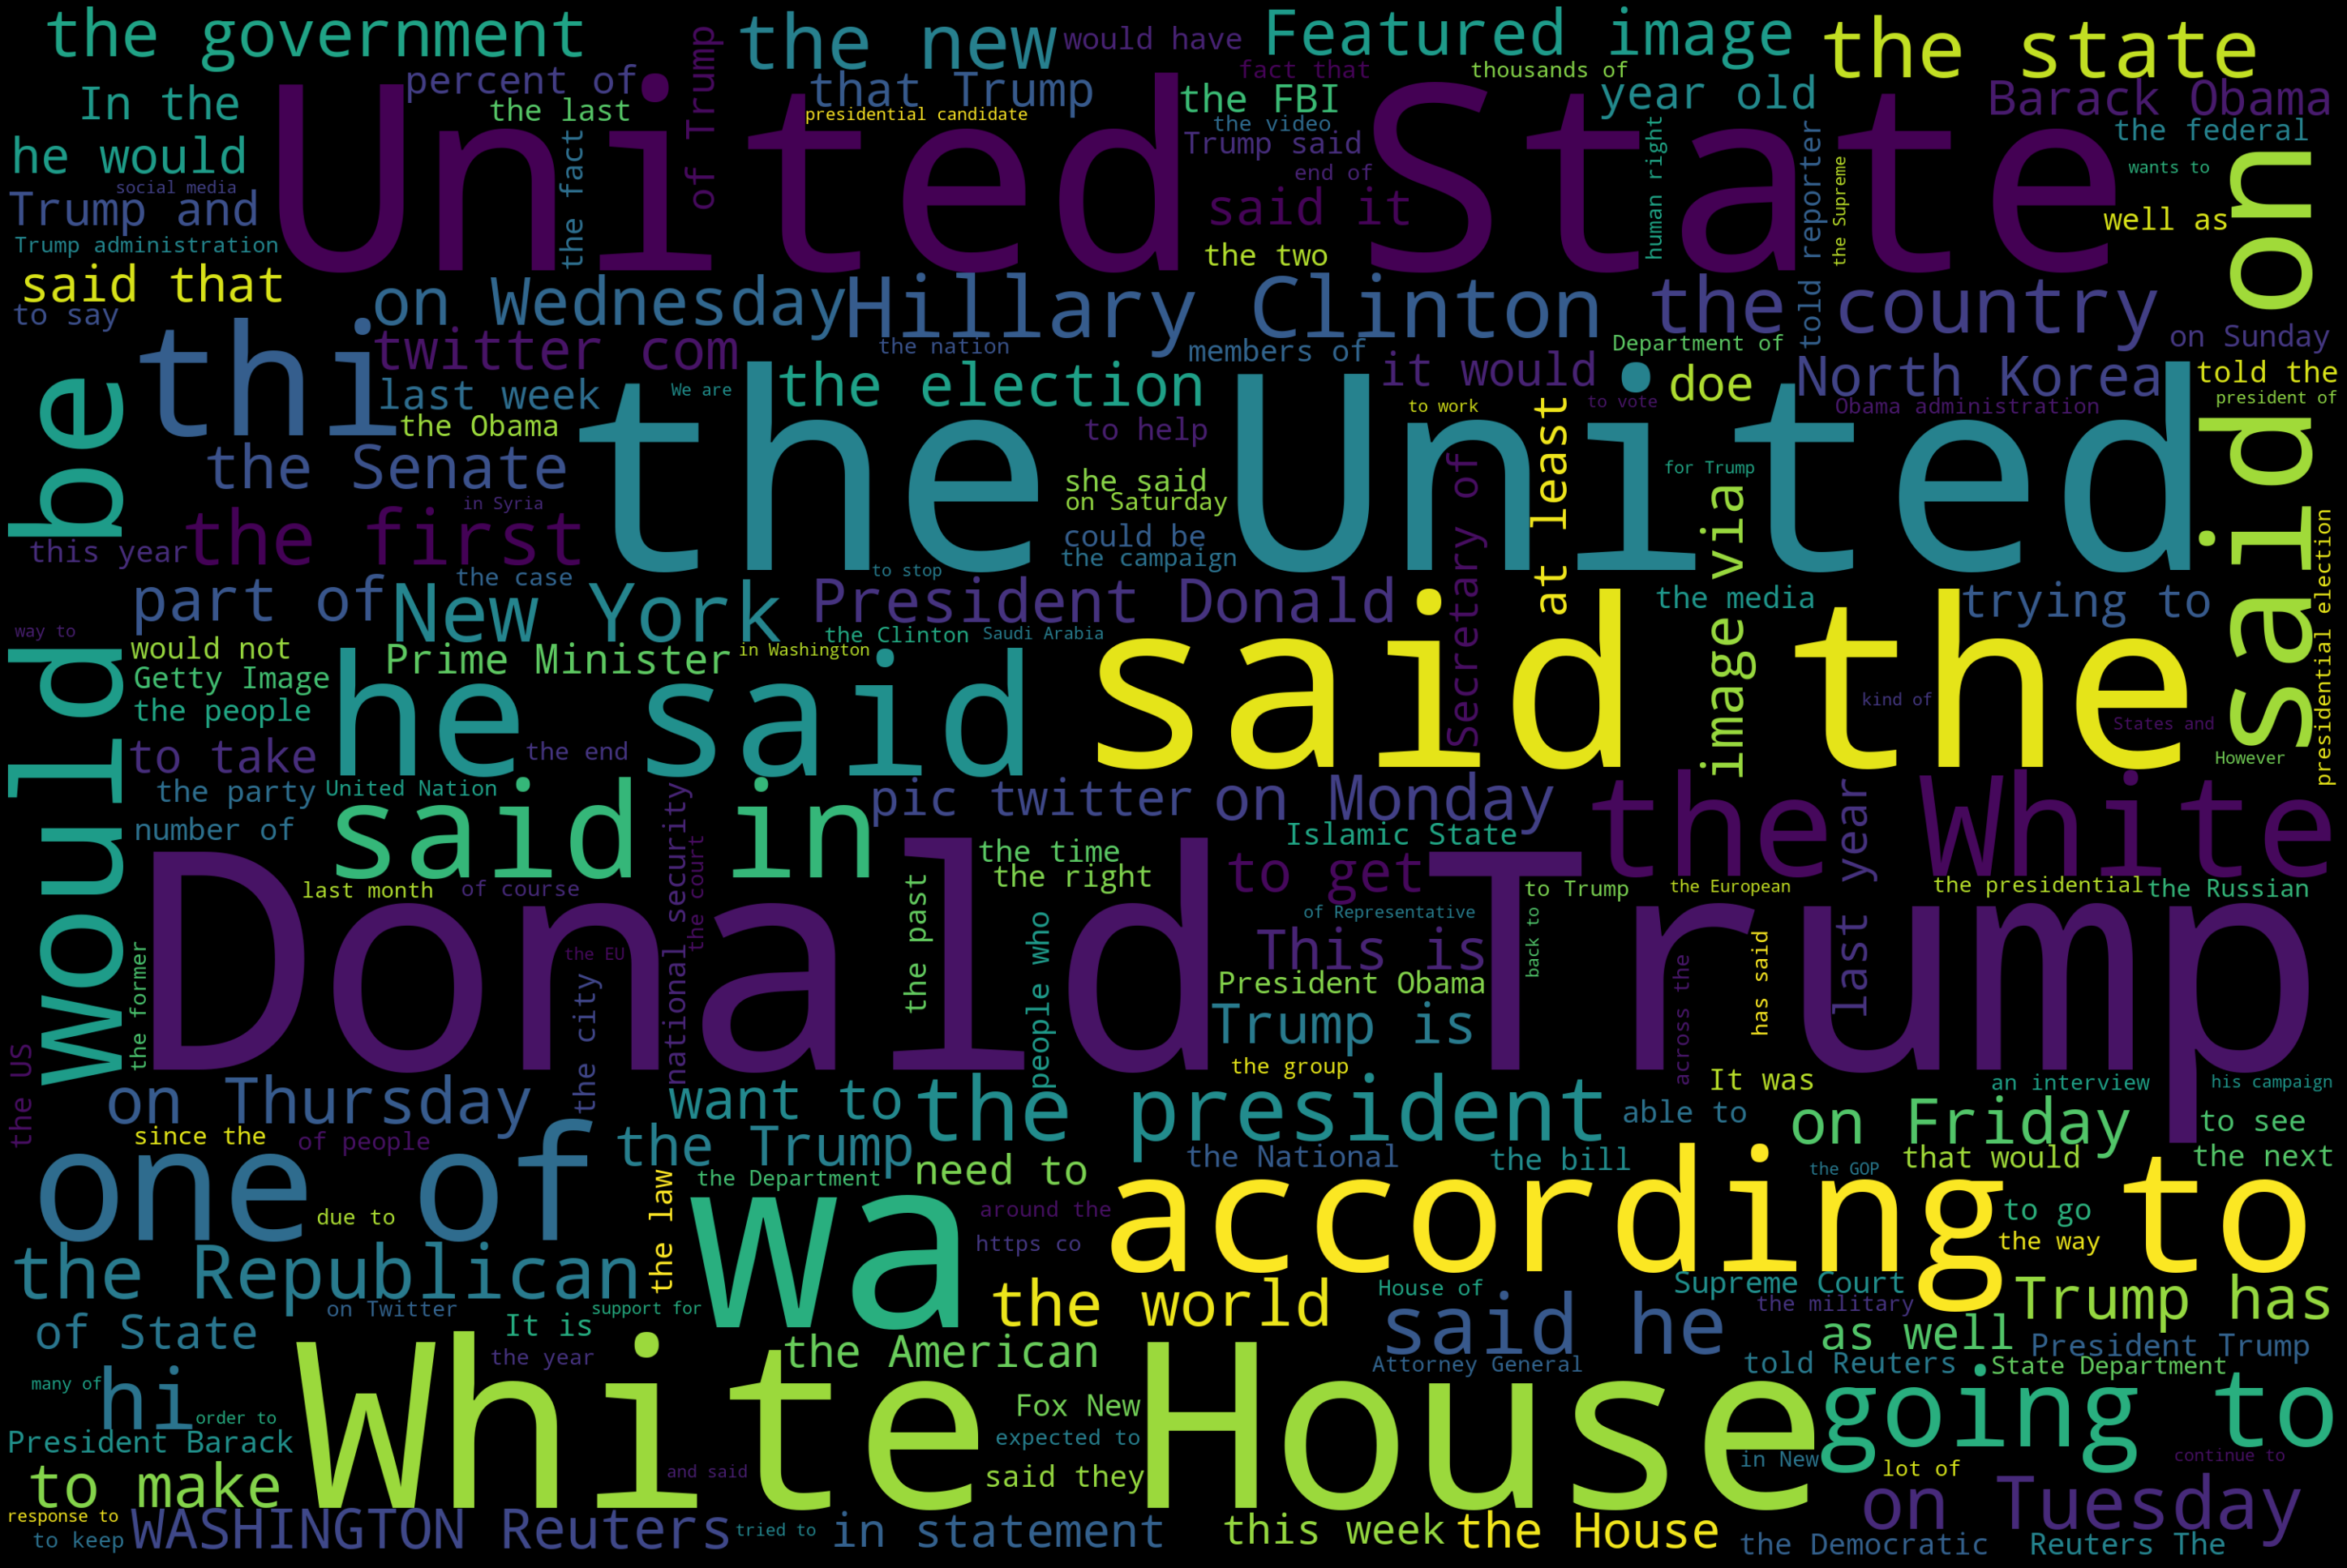

In [72]:
#WordCloud For Clean Text 
text = ''
for text_clean in text_clean.text.values:
    text += f" {text_clean}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# Modelling and Predictions

As we progress through to the modelling and predicitons, note that text classification is done in the same way as all other classification models. First, the text is vectorized into a set of numeric features. Then, a standard machine learning classifier is applied. NLP libraries often include vectorizers and ML models that work particularly well with text.


## Train/Test Split

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
# Define X and y. This is neccessary for the steps below:
y = news.target
y.head()

0    fake
1    fake
2    fake
3    fake
4    fake
Name: target, dtype: object

In [31]:
y.tail()

44893    true
44894    true
44895    true
44896    true
44897    true
Name: target, dtype: object

In [32]:
X_train, X_test, y_train, y_test = train_test_split(text_clean['text'], y, test_size=0.33, random_state=100)

In [33]:
X_train.head()

21497    The liberal pundits are pretty frustrated by t...
27160    WASHINGTON (Reuters) - A senior U.S. senator s...
3277     Former President George H. W. Bush can teach D...
7886     Alabama Republicans were quickly trying to ban...
24170    (Reuters) - The U.S wind energy industry on Fr...
Name: text, dtype: object

In [34]:
y_train.head()

21497    fake
27160    true
3277     fake
7886     fake
24170    true
Name: target, dtype: object

In [35]:
# Call length on the training data to see how many observations we have
train_set_size = len(X_train)
print('Number of training rows = {:,d}'.format(train_set_size))

Number of training rows = 30,081


In [36]:
# Call length on the training data to see how many observations we have
test_set_size = len(X_test)
print('Number of test rows = {:,d}'.format(test_set_size))

Number of test rows = 14,817


## Count and Tfidf Vectorizers: Bag of Words

We need to vectorize the text by converting it into numeric components. This process allows the machine learning model to interpret the previously unstructured text.

In NLP rows are documents, columns are terms (aka "tokens" or "features", individual words in this situation).

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

Let's fit a count vectorizer that removes stopwords. The count vectorizer will count the occurence of certain words, creating a bag of words

In [38]:
# Set the vectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english')

In [39]:
# Fit the vectorizer
count_train = count_vectorizer.fit_transform(X_train.values)

In [40]:
count_train

<30081x104737 sparse matrix of type '<class 'numpy.int64'>'
	with 4631564 stored elements in Compressed Sparse Row format>

We now need to **transform** the X_train values to encode each as a vector.

In [41]:
# Transform the vectorizer
count_test = count_vectorizer.transform(X_test.values)

In [42]:
# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[:10])

['00', '000', '0000', '00000017', '00004', '000048', '000063', '00007', '00042', '0005']


Let's do the same as we did above but with a tfidf vectorizer. The **term frequency inverse document frequency** vectorizer is a powerful, data driven to approach to converting a collection of raw documents to a matrix. Essentially it automatically removes meaningless words within the text corpus, this should improve the model quality later on.

In [43]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

In [45]:
# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)


In [46]:
# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

['00', '000', '0000', '00000017', '00004', '000048', '000063', '00007', '00042', '0005']


In [47]:
# Print the first 5 vectors of the tfidf training data
print(tfidf_train.A[:5])

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.03090231 0.         ... 0.         0.         0.        ]]


We now create dataframes for the **count and tfidf** vectorizers.

In [48]:
# Create the CountVectorizer DataFrame: count_df
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

# Print the head of count_df
print(count_df.head())


   00  000  0000  00000017  00004  000048  000063  00007  00042  0005  ...  \
0   0    0     0         0      0       0       0      0      0     0  ...   
1   0    0     0         0      0       0       0      0      0     0  ...   
2   0    0     0         0      0       0       0      0      0     0  ...   
3   0    0     0         0      0       0       0      0      0     0  ...   
4   0    1     0         0      0       0       0      0      0     0  ...   

   zzn3bqnfsk  zzpx_bzka40police  zzqvyk8xif  zzsg90pbf6  zzucqevt3m  \
0           0                  0           0           0           0   
1           0                  0           0           0           0   
2           0                  0           0           0           0   
3           0                  0           0           0           0   
4           0                  0           0           0           0   

   zzuml4hkoc  zzzzaaaacccchhh  zzzzzzzz  zzzzzzzzzzzzz  émigré  
0           0                0  

In [49]:
# Print the head of tfidf_df
print(tfidf_df.tail())

        00  000  0000  00000017  00004  000048  000063  00007  00042  0005  \
30076  0.0  0.0   0.0       0.0    0.0     0.0     0.0    0.0    0.0   0.0   
30077  0.0  0.0   0.0       0.0    0.0     0.0     0.0    0.0    0.0   0.0   
30078  0.0  0.0   0.0       0.0    0.0     0.0     0.0    0.0    0.0   0.0   
30079  0.0  0.0   0.0       0.0    0.0     0.0     0.0    0.0    0.0   0.0   
30080  0.0  0.0   0.0       0.0    0.0     0.0     0.0    0.0    0.0   0.0   

       ...  zzn3bqnfsk  zzpx_bzka40police  zzqvyk8xif  zzsg90pbf6  zzucqevt3m  \
30076  ...         0.0                0.0         0.0         0.0         0.0   
30077  ...         0.0                0.0         0.0         0.0         0.0   
30078  ...         0.0                0.0         0.0         0.0         0.0   
30079  ...         0.0                0.0         0.0         0.0         0.0   
30080  ...         0.0                0.0         0.0         0.0         0.0   

       zzuml4hkoc  zzzzaaaacccchhh  zzzzzzzz

In [50]:
# Calculate the difference in columns: difference
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

{'said'}


In [51]:
# Check whether the DataFrames are equal
print(count_df.equals(tfidf_df))

False



## Training Classification Models with Scikit-Learn 

In [52]:
from sklearn.pipeline import Pipeline

In [53]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB

In [54]:
X_train

21497    The liberal pundits are pretty frustrated by t...
27160    WASHINGTON (Reuters) - A senior U.S. senator s...
3277     Former President George H. W. Bush can teach D...
7886     Alabama Republicans were quickly trying to ban...
24170    (Reuters) - The U.S wind energy industry on Fr...
                               ...                        
16304    Four employees at an Oklahoma Department of Ve...
79       Yesterday, after the father of one of the UCLA...
12119    Hey Michelle Guess what? For the first time in...
14147     THE BIG QUESTION WITH THE EXTRADITION OF THE ...
38408    SOCHI, Russia (Reuters) - President Vladimir P...
Name: text, Length: 30081, dtype: object

In [55]:
y_train

21497    fake
27160    true
3277     fake
7886     fake
24170    true
         ... 
16304    fake
79       fake
12119    fake
14147    fake
38408    true
Name: target, Length: 30081, dtype: object

## Naive-Bayes Classifier
The **MNB Classifier** is a suitable model for this **NLP** problem due to it's capacity to handle sparseness in data more effectivley than alternative models. 

##### Training and Testing the fake news model with the Count Vectorizer

In [56]:
# Naive-Bayes Classification Model
nb_classifier = MultinomialNB()

In [57]:
nb_classifier.fit(count_train, y_train)

MultinomialNB()

In [58]:
pred = nb_classifier.predict(count_test)

##### Model 1 Accuracy

In [59]:
metrics.accuracy_score(y_test, pred)


0.9628804751299184

In [60]:
yhat = nb_classifier.predict(count_test)
yhat[0:10]

array(['fake', 'true', 'true', 'true', 'fake', 'true', 'true', 'fake',
       'true', 'fake'], dtype='<U4')

### Model Evaluation

##### Confusion Matrix

Let's run a confusion matrix over the model to further check it's performance

In [61]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [62]:
y_test.head()

11383    fake
40964    true
31695    true
27801    true
7559     fake
Name: target, dtype: object

In [63]:
# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=['fake', 'true'])
print(cm)

[[7386  330]
 [ 220 6881]]


In [64]:
def plot_confusion_matrix(cm, classes, normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without Normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment='center',
                color="white" if cm1[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')


              precision    recall  f1-score   support

        fake       0.97      0.96      0.96      7716
        true       0.95      0.97      0.96      7101

    accuracy                           0.96     14817
   macro avg       0.96      0.96      0.96     14817
weighted avg       0.96      0.96      0.96     14817

Confusion Matrix, without Normalization
[[7386  330]
 [ 220 6881]]


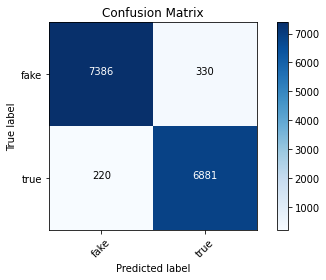

In [65]:
# Calculate the confusion matrix: cm
cm1 = metrics.confusion_matrix(y_test, pred, labels=['fake', 'true'])
np.set_printoptions(precision=2)

print(classification_report(y_test, pred))

plt.figure()
plot_confusion_matrix(cm1, classes=['fake', 'true'], normalize=False, title='Confusion Matrix')

#print(cm)

### Training and testing the fake news model with TfidfVectorizer**

In [66]:
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

In [67]:
# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

MultinomialNB()

In [68]:
# Create the predicted tags: pred
pred_tf = nb_classifier.predict(tfidf_test)

##### Model 2 Accuracy

In [69]:
# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred_tf)
#print(score)
print("accuracy: {}%".format(round(accuracy_score(y_test, pred_tf)*100,2)))

accuracy: 94.82%


The **tfidf MNB model** has an accuracy of **94%** compared to the **count MNB model** which has an accuracy of 96%.

In [70]:
yhat = nb_classifier.predict(tfidf_test)
yhat[0:10]

array(['fake', 'true', 'true', 'true', 'fake', 'true', 'fake', 'fake',
       'true', 'fake'], dtype='<U4')

### Model Evaluation

##### Confusion Matrix

In [71]:
# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred_tf, labels=['fake', 'true'])
print(cm)

[[7307  409]
 [ 359 6742]]


In [72]:
def plot_confusion_matrix(cm, classes, normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without Normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment='center',
                color="white" if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')


              precision    recall  f1-score   support

        fake       0.95      0.95      0.95      7716
        true       0.94      0.95      0.95      7101

    accuracy                           0.95     14817
   macro avg       0.95      0.95      0.95     14817
weighted avg       0.95      0.95      0.95     14817

Confusion Matrix, without Normalization
[[7307  409]
 [ 359 6742]]


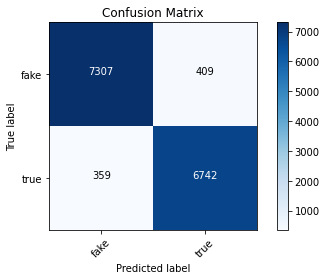

In [73]:
# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred_tf, labels=['fake', 'true'])
np.set_printoptions(precision=2)

print(classification_report(y_test, pred_tf))

plt.figure()
plot_confusion_matrix(cm, classes=['fake', 'true'], normalize=False, title='Confusion Matrix')

#print(cm)

### Model Tuning

Let's try to improve the model by testing different levels of **alphas**.

In [60]:
# Create the list of alphas: alphas
alphas = np.arange(0, 1, .1)

In [61]:
def train_and_predict(alpha):
    # Instantiate classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to training data
    nb_classifier.fit(tfidf_train, y_train)
    # Predict the labels
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy
    score = metrics.accuracy_score(y_test, pred)
    return score

In [62]:
# Iterate over the different alphas and print the corresponding score

for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()
    

Alpha:  0.0
Score:  0.9582911520550719

Alpha:  0.1


/Users/joseph_arber/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Score:  0.9539042991158804

Alpha:  0.2
Score:  0.9520145778497672

Alpha:  0.30000000000000004
Score:  0.9512046973071472

Alpha:  0.4
Score:  0.9498548964027805

Alpha:  0.5
Score:  0.9494499561314707

Alpha:  0.6000000000000001
Score:  0.948910035769724

Alpha:  0.7000000000000001
Score:  0.9490450158601607

Alpha:  0.8
Score:  0.948707565634069

Alpha:  0.9
Score:  0.9484376054531957



### Model Evaluation 

**How well have the models performed?**

In [74]:
# Get the class labels: class_labels
class_labels = nb_classifier.classes_

# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

In [75]:
# Print the first class label and the top 20 feat with weights entries
print(class_labels[0], feat_with_weights[:20])


fake [(-12.369438013472871, '00000017'), (-12.369438013472871, '000048'), (-12.369438013472871, '00007'), (-12.369438013472871, '000american'), (-12.369438013472871, '000dillon000'), (-12.369438013472871, '000ecuador'), (-12.369438013472871, '000have'), (-12.369438013472871, '000kyrgyzstan'), (-12.369438013472871, '000oman'), (-12.369438013472871, '000saudi'), (-12.369438013472871, '000th'), (-12.369438013472871, '000that'), (-12.369438013472871, '001romney'), (-12.369438013472871, '00220'), (-12.369438013472871, '002singapore'), (-12.369438013472871, '004saint'), (-12.369438013472871, '00654'), (-12.369438013472871, '00684'), (-12.369438013472871, '007'), (-12.369438013472871, '0075')]


In [76]:
# Print the second class label and the bottom 20 feat with weights entries
print(class_labels[1], feat_with_weights[-20:])

true [(-7.129277930349629, 'party'), (-7.113844041937376, 'tax'), (-7.079466109855665, 'korea'), (-7.068116054345596, 'election'), (-7.065839703957959, 'minister'), (-7.0563003815859355, 'senate'), (-7.022949162151747, 'told'), (-6.98091523460531, 'north'), (-6.969535587379604, 'new'), (-6.872546470408288, 'trumps'), (-6.860338756945235, 'united'), (-6.8450495520066985, 'states'), (-6.8121272688063375, 'republican'), (-6.810442014677322, 'washington'), (-6.781911819978807, 'government'), (-6.735263657964133, 'state'), (-6.706125982789248, 'house'), (-6.524926490310611, 'president'), (-6.30648453208755, 'reuters'), (-6.158447392519578, 'trump')]


In [77]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        fake       0.97      0.96      0.96      7716
        true       0.95      0.97      0.96      7101

    accuracy                           0.96     14817
   macro avg       0.96      0.96      0.96     14817
weighted avg       0.96      0.96      0.96     14817



# Machine Learning Pipeline

Let's instantiate some alternative models with the help of a pipeline

### Support Vector Classifier

In [67]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

We want to compare the accuracy of **MNB Model** to the **Linear Support Vector Machine Model.**

In [68]:
pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('selector', SelectKBest(k=100)),
    ('SVC', LinearSVC())])

# Train pipeline
SVC = pipeline.fit(X_train, y_train)
# Fit pipeline
pred2 = SVC.predict(X_test)
# Print score
print("accuracy: {}%".format(round(accuracy_score(y_test, pred2)*100,2)))

accuracy: 98.8%


In [69]:
# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred2, labels=['fake', 'true'])
print(cm)

[[7622   94]
 [  84 7017]]


In [70]:
def plot_confusion_matrix(cm, classes, normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without Normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment='center',
                color="white" if cm1[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')


              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      7716
        true       0.99      0.99      0.99      7101

    accuracy                           0.99     14817
   macro avg       0.99      0.99      0.99     14817
weighted avg       0.99      0.99      0.99     14817

Confusion Matrix, without Normalization
[[7622   94]
 [  84 7017]]


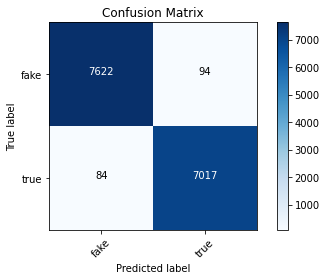

In [71]:
# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred2, labels=['fake', 'true'])
np.set_printoptions(precision=2)

print(classification_report(y_test, pred2))

plt.figure()
plot_confusion_matrix(cm, classes=['fake', 'true'], normalize=False, title='Confusion Matrix')

#print(cm)

In [72]:
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      7716
        true       0.99      0.99      0.99      7101

    accuracy                           0.99     14817
   macro avg       0.99      0.99      0.99     14817
weighted avg       0.99      0.99      0.99     14817



Looking at the cross validation scores we can see that model performance is around 98%. 

In [73]:
cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5)

array([0.99, 0.99, 0.99, 0.99, 0.99])

In [74]:
from sklearn.model_selection import cross_val_predict
predicted_targets = cross_val_predict(pipeline, X_train, y_train)

Below we have the predicted labels, useful for checking the model performance.

In [75]:
predicted_targets

array(['fake', 'true', 'fake', ..., 'fake', 'fake', 'true'], dtype=object)

### Logistic Regression Model

We deploy a logistic regression model due to its high interpretability in comparison to other models.

In [80]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('selector', SelectKBest(k=100)),
                 ('log_model', LogisticRegression(C=10.0, max_iter=200))
                ])

# Train pipeline
log_model = pipe.fit(X_train, y_train)
# Fit pipeline
pred3 = SVC.predict(X_test)
# Print score
print("accuracy: {}%".format(round(accuracy_score(y_test, pred3)*100,2)))

/Users/joseph_arber/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy: 98.8%


In [116]:
#pred3 = log_reg.predict(count_test)
#print("accuracy: {}%".format(round(accuracy_score(y_test, pred3)*100,2)))

accuracy: 98.53%


In [81]:
print(confusion_matrix(y_test, pred3))

[[7622   94]
 [  84 7017]]


In [82]:
print(classification_report(y_test, pred3))

              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      7716
        true       0.99      0.99      0.99      7101

    accuracy                           0.99     14817
   macro avg       0.99      0.99      0.99     14817
weighted avg       0.99      0.99      0.99     14817



In [83]:
cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv=5)

/Users/joseph_arber/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/joseph_arber/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

array([0.99501413, 0.99401596, 0.9943484 , 0.99468085, 0.99285239])

Checking the cross-validation scores, we get 99% accuracy, consistently.

## Hyperparameter Tuning and Grid Search

Grid Search CV runs an exhaustive search over specified parameter values for an estimator.

In [76]:
from sklearn.model_selection import GridSearchCV, cross_val_score

Let's tune some of the model parameters.

In [77]:
# *This is the pipeline from above:

pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('selector', SelectKBest(k=100)),
    ('SVC', LinearSVC())
])

**Let's run a grid search through the optimal hyperparameters:**

1. Estimator is the classifier or regressor that we want to tune. 
2. In this case it's SGDClassifier 
3. Param_grid is a dictionary of hyperparameters and a selection of values to test. 
4. The keys of the dictionary must 3be parameters for the estimator. For an SGDClassifier we have things like alpha penalty.
5. Scoring is the metric we want to use to measure which parameter set is best. We look at accuracy.
6. cv the number of folds to use.

In [78]:
# Run a grid search to find the optimum parameters

grid_search = GridSearchCV(estimator = pipeline,
                          param_grid={
                              'selector__k':[50,100,1000]
                          },
                          cv=3
                          )

In [79]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('selector', SelectKBest(k=100)),
                                       ('SVC', LinearSVC())]),
             param_grid={'selector__k': [50, 100, 1000]})

In [99]:
grid_search.cv_results_

{'mean_fit_time': array([5.57449794, 5.25479801, 6.07305042]),
 'std_fit_time': array([0.48067196, 0.02016892, 0.80188844]),
 'mean_score_time': array([2.45098829, 2.41130702, 2.76148391]),
 'std_score_time': array([0.06553305, 0.02918204, 0.15165873]),
 'param_selector__k': masked_array(data=[50, 100, 1000],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'selector__k': 50}, {'selector__k': 100}, {'selector__k': 1000}],
 'split0_test_score': array([0.98364416, 0.9873342 , 0.99242046]),
 'split1_test_score': array([0.98543931, 0.98643662, 0.99152289]),
 'split2_test_score': array([0.98244739, 0.98613743, 0.99172235]),
 'mean_test_score': array([0.98384362, 0.98663608, 0.99188857]),
 'std_test_score': array([0.00122956, 0.00050853, 0.00038482]),
 'rank_test_score': array([3, 2, 1], dtype=int32)}

What are the best K selector parameters?

In [83]:
grid_search.best_score_

0.991888567534324

In [84]:
grid_search.best_params_

{'selector__k': 1000}

1000 parameters are most suitable for the model.

# Next Steps and Findings


We succesfully programmed a fake news classifier. The most suitable model for this problem is the Linear Support Vector Machine, it was able to consistently news articles with around 98% accuracy. 

Going forward we could fit the model to the titles of the articles, rather than the text, doing this could provide more interesting results.

Bearing in mind that we rigourously cleaned the data, intuitivley the models did not have to work that hard to classify that news articles. It may have been interesting to show the model uncleaned data and observe its performance accuracy. 

**Alternative Models:**

Although the model accuracy was high, perhaps it could be improved by leveraging powerful ensemble methods such as XGBoost or Gradient Boosting. Results show that these models almost always perform more consistently on classification problems.